#  Machine Learining Practical: Coursework 3


## Training Deep Neural Nteworks on CIFAR-10

In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import datetime
import os
from collections import OrderedDict
from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm
from tensorflow.python.ops import control_flow_ops


%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)
valid_data2 = CIFAR10DataProvider('valid', batch_size=10000)

KeyError: 'MLP_DATA_DIR'

In [4]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [5]:
def fully_connected_layer_with_weights(inputs, input_dim, output_dim, weight_params, nonlinearity=tf.nn.relu):
    weights = weight_params
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [6]:
def plot_error_and_accuracy(diction, filename):
    fig = plt.figure(figsize=(12, 6))
    fig2 = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax3 = fig2.add_subplot(1,2,1)
    ax4 = fig2.add_subplot(1,2,2)
    x=np.arange(80) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label=str(labels))
        ax2.plot(x, 
                 error_valid_all, label=str(labels))
        ax3.plot(x, 
                 acc_all, label=str(labels))
        ax4.plot(x, 
                 acc_valid_all, label=str(labels))

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    fig.tight_layout() 
    fig.savefig(filename+'_err.png') 
    #ax2.set_yscale('log')
    
    
    ax3.legend(loc=0)
    ax3.set_xlabel('Epoch number')
    ax3.set_ylabel('Training set accuracy')
    ax4.legend(loc=0)
    ax4.set_xlabel('Epoch number')
    ax4.set_ylabel('Validation set accuracy')
    fig2.tight_layout() # This minimises whitespace around the axes.
    fig2.savefig(filename+'_acc.png') # Save figure to current directory in PDF format


In [7]:
def plot_error_and_accuracy_single(diction, filename):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    x=np.arange(100) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label='Training Set Error')
        ax1.plot(x, 
                 error_valid_all, label='Validation Set Error')
        ax2.plot(x, 
                 acc_all, label='Training Set Accuracy')
        ax2.plot(x, 
                 acc_valid_all, label='Validation Set Accuracy')

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training & Validation set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Training & Validation set Accuracy')
    fig.tight_layout() 
    fig.savefig(filename+'.png') 
    #ax2.set_yscale('log')

### Experiment1: Training with different layer width

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
with tf.Session() as sess:
    sess.run(c)

In [10]:
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [ ]:
seed = 24102016 
rng = np.random.RandomState(seed)


run_info = {}
params = [10,50,200, 500, 1000] # The current parameter is the hidden layer width
labels = ['neurons_10','neurons_50','neurons_200','neurons_500','neurons_1000']

for param, label in zip(params, labels):

    tf.reset_default_graph()
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    num_hidden = param # The parameter of the experiment
    
    
    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
    
    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(config=config) as sess:
        sess.run(init)
        print('Model: {}'.format(label))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: neurons_10
End of epoch 05: err(train)=2.07 acc(train)=0.18
                 err(valid)=2.06 acc(valid)=0.19
End of epoch 10: err(train)=2.04 acc(train)=0.19
                 err(valid)=2.04 acc(valid)=0.19
End of epoch 15: err(train)=2.03 acc(train)=0.19
                 err(valid)=2.07 acc(valid)=0.18
End of epoch 20: err(train)=2.03 acc(train)=0.19
                 err(valid)=2.05 acc(valid)=0.19
End of epoch 25: err(train)=2.03 acc(train)=0.20
                 err(valid)=2.03 acc(valid)=0.19
End of epoch 30: err(train)=2.03 acc(train)=0.19
                 err(valid)=2.03 acc(valid)=0.19
End of epoch 35: err(train)=2.02 acc(train)=0.19
                 err(valid)=2.03 acc(valid)=0.18
End of epoch 40: err(train)=2.02 acc(train)=0.19
                 err(valid)=2.04 acc(valid)=0.18
End of epoch 45: err(train)=2.02 acc(train)=0.19
                 err(valid)=2.03 acc(valid)=0.19
End of epoch 50: err(train)=2.02 acc(train)=0.19
                 err(valid)=2.03 acc(valid)=0.19
Mo

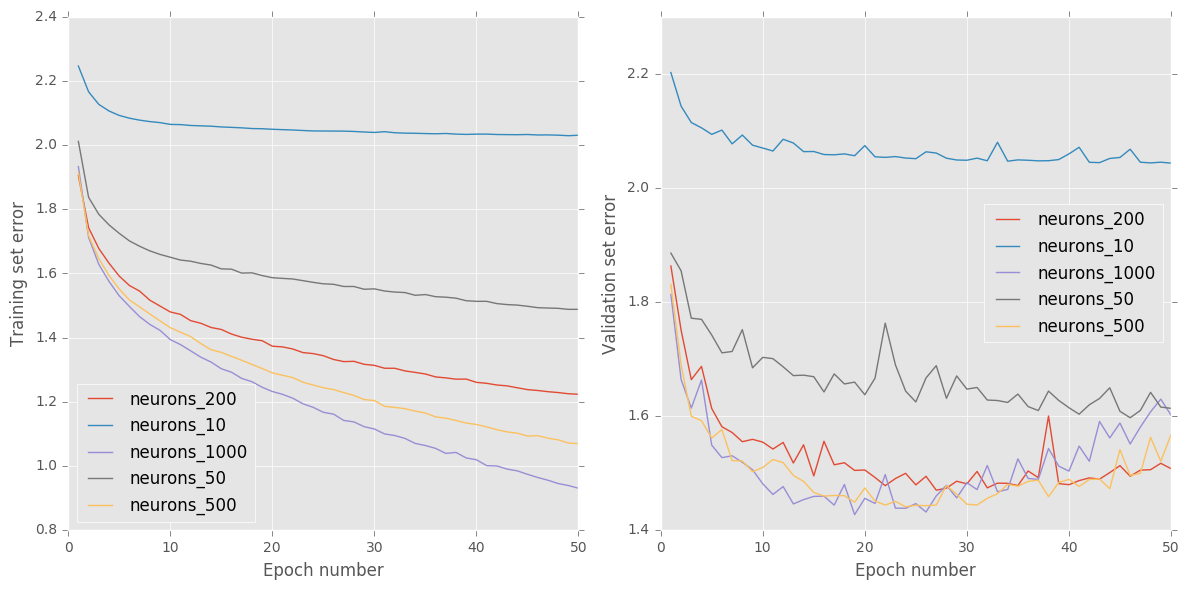

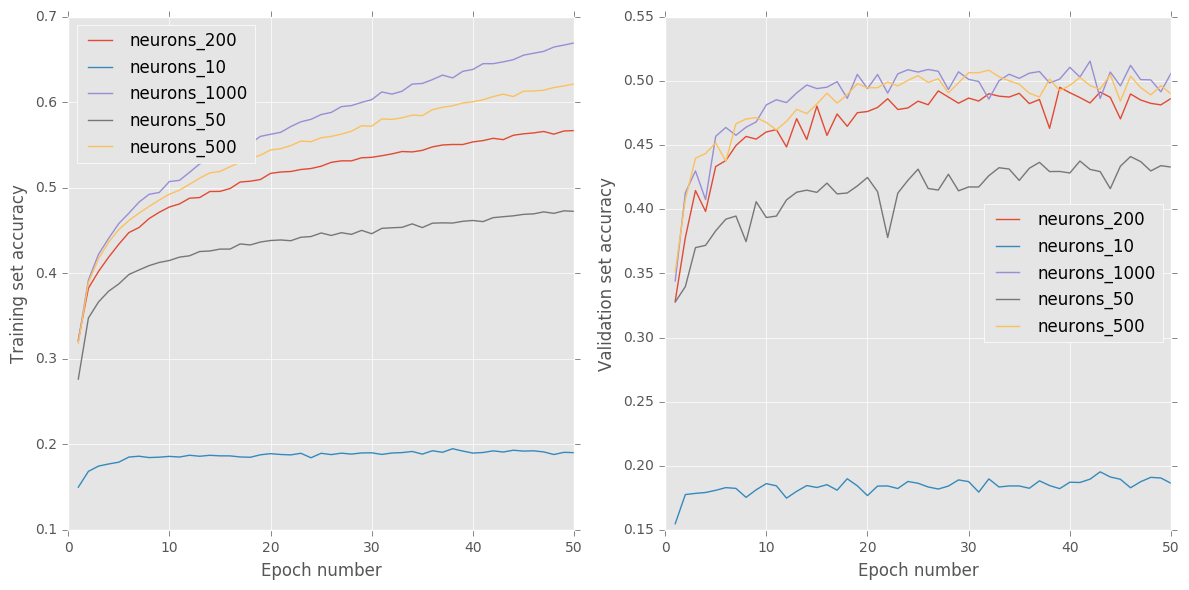

In [10]:
plot_error_and_accuracy(run_info,'Layer_width')

### Experiment 2: Training with different activation functions

In [6]:
    run_info = {}
    
    labels = ['Sigmoid_Layer','Tanh_Layer','ELU_Layer','ReLu_Layer']



    tf.reset_default_graph()
   
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    

    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, tf.nn.sigmoid)
        
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: Sigmoid_Layer
End of epoch 05: err(train)=1.52 acc(train)=0.46
                 err(valid)=1.57 acc(valid)=0.45
End of epoch 10: err(train)=1.38 acc(train)=0.51
                 err(valid)=1.48 acc(valid)=0.48
End of epoch 15: err(train)=1.28 acc(train)=0.55
                 err(valid)=1.43 acc(valid)=0.50
End of epoch 20: err(train)=1.19 acc(train)=0.58
                 err(valid)=1.41 acc(valid)=0.50
End of epoch 25: err(train)=1.12 acc(train)=0.61
                 err(valid)=1.40 acc(valid)=0.51
End of epoch 30: err(train)=1.05 acc(train)=0.63
                 err(valid)=1.43 acc(valid)=0.50


In [8]:
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    
    
    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden, tf.nn.tanh)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: Tanh_Layer
End of epoch 05: err(train)=1.60 acc(train)=0.43
                 err(valid)=1.63 acc(valid)=0.42
End of epoch 10: err(train)=1.50 acc(train)=0.46
                 err(valid)=1.59 acc(valid)=0.44
End of epoch 15: err(train)=1.44 acc(train)=0.49
                 err(valid)=1.55 acc(valid)=0.46
End of epoch 20: err(train)=1.38 acc(train)=0.51
                 err(valid)=1.54 acc(valid)=0.46
End of epoch 25: err(train)=1.35 acc(train)=0.52
                 err(valid)=1.55 acc(valid)=0.45
End of epoch 30: err(train)=1.33 acc(train)=0.53
                 err(valid)=1.59 acc(valid)=0.45


In [9]:
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    
    
    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden,tf.nn.elu)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: ELU_Layer
End of epoch 05: err(train)=1.52 acc(train)=0.46
                 err(valid)=1.54 acc(valid)=0.46
End of epoch 10: err(train)=1.36 acc(train)=0.51
                 err(valid)=1.51 acc(valid)=0.47
End of epoch 15: err(train)=1.26 acc(train)=0.55
                 err(valid)=1.47 acc(valid)=0.49
End of epoch 20: err(train)=1.17 acc(train)=0.59
                 err(valid)=1.43 acc(valid)=0.50
End of epoch 25: err(train)=1.08 acc(train)=0.62
                 err(valid)=1.45 acc(valid)=0.52
End of epoch 30: err(train)=1.00 acc(train)=0.65
                 err(valid)=1.52 acc(valid)=0.51


In [11]:
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
  
    
    
    with tf.name_scope('fc-layer-1'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: ReLu_Layer
End of epoch 05: err(train)=1.56 acc(train)=0.45
                 err(valid)=1.57 acc(valid)=0.45
End of epoch 10: err(train)=1.44 acc(train)=0.49
                 err(valid)=1.54 acc(valid)=0.46
End of epoch 15: err(train)=1.35 acc(train)=0.52
                 err(valid)=1.48 acc(valid)=0.48
End of epoch 20: err(train)=1.29 acc(train)=0.54
                 err(valid)=1.47 acc(valid)=0.49
End of epoch 25: err(train)=1.24 acc(train)=0.56
                 err(valid)=1.47 acc(valid)=0.50
End of epoch 30: err(train)=1.19 acc(train)=0.58
                 err(valid)=1.46 acc(valid)=0.50


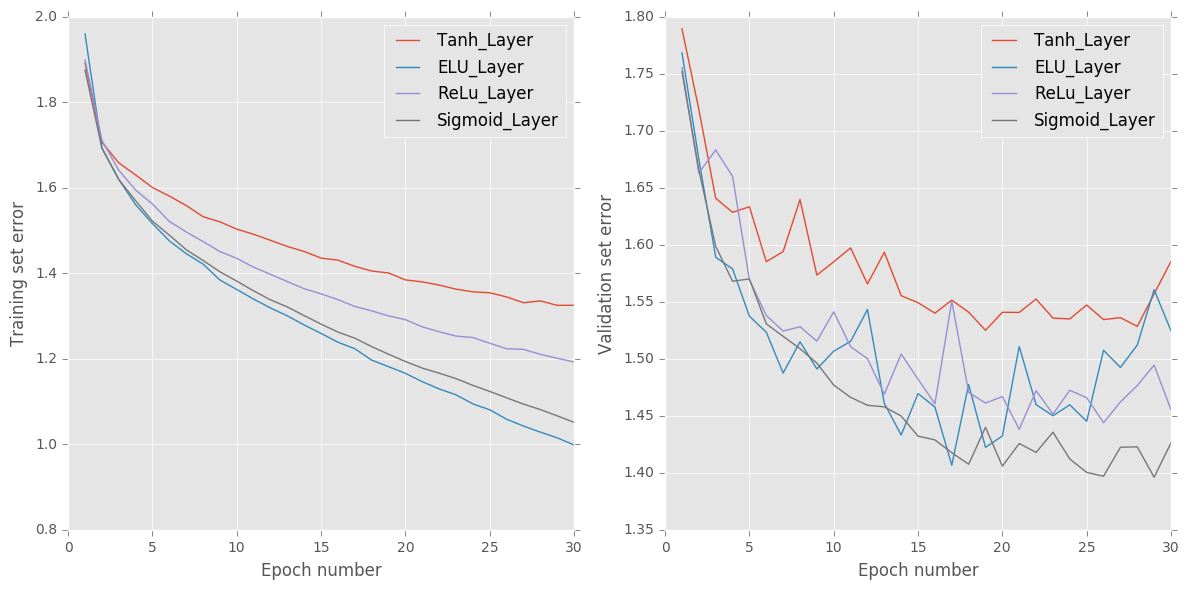

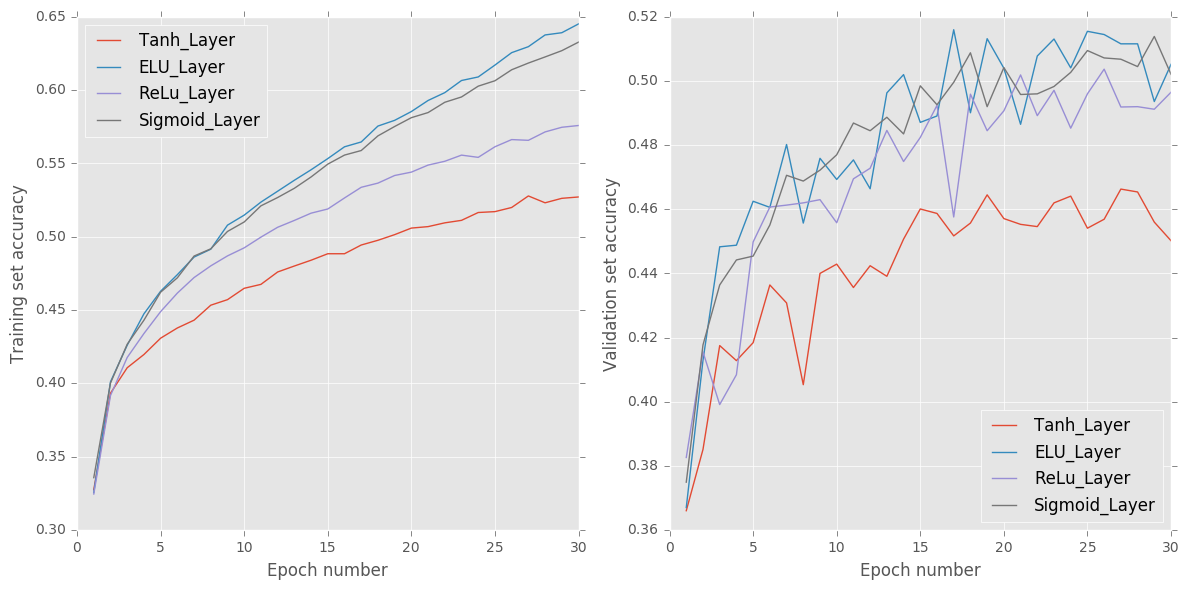

In [12]:
plot_error_and_accuracy(run_info,'Activation_functions')

### Experiment 3: Training with different number of hidden layers 

In [10]:
    run_info = {}
    num_hidden = 512
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    labels = ['1_hidden_layer','2_hidden_layer','3_hidden_layer','4_hidden_layer','5_hidden_layer']



    tf.reset_default_graph()

    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    with tf.name_scope('weights_biases'):
        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                    stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, train_data.num_classes], 
                                                    stddev=2. / (num_hidden + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))
    
        
    
    with tf.name_scope('fc-layer-1'):
        hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    with tf.name_scope('output-layer'):
        outputs = tf.matmul(hidden_1, weights_2) + biases_2

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(max(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 1_hidden_layer
End of epoch 05: err(train)=1.5467 acc(train)=0.4516
                 err(valid)=1.5631 acc(valid)=0.4536
End of epoch 10: err(train)=1.4214 acc(train)=0.4984
                 err(valid)=1.4988 acc(valid)=0.4782
End of epoch 15: err(train)=1.3463 acc(train)=0.5235
                 err(valid)=1.4838 acc(valid)=0.4851
End of epoch 20: err(train)=1.2925 acc(train)=0.5439
                 err(valid)=1.4701 acc(valid)=0.4883
End of epoch 25: err(train)=1.2354 acc(train)=0.5641
                 err(valid)=1.4614 acc(valid)=0.5012
End of epoch 30: err(train)=1.1908 acc(train)=0.5781
                 err(valid)=1.5069 acc(valid)=0.4879
Max_Validation_Error: 1.83056001961 
Max_Validation_Accuracy: 0.506399999261 


In [11]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
   
    with tf.name_scope('weights_biases'):
        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_1 + train_data.num_classes)**0.5))  
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([train_data.num_classes]))
        
    with tf.name_scope('fc-layer-1'):
        hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    with tf.name_scope('fc-layer-2'):
        hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    with tf.name_scope('output-layer'):
        outputs = tf.matmul(hidden_2, weights_3) + biases_3

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(max(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 2_hidden_layer
End of epoch 05: err(train)=1.5092 acc(train)=0.4599
                 err(valid)=1.5522 acc(valid)=0.4517
End of epoch 10: err(train)=1.3602 acc(train)=0.5177
                 err(valid)=1.5025 acc(valid)=0.4707
End of epoch 15: err(train)=1.2392 acc(train)=0.5600
                 err(valid)=1.4699 acc(valid)=0.4907
End of epoch 20: err(train)=1.1414 acc(train)=0.5932
                 err(valid)=1.4435 acc(valid)=0.5082
End of epoch 25: err(train)=1.0599 acc(train)=0.6234
                 err(valid)=1.4725 acc(valid)=0.5089
End of epoch 30: err(train)=0.9802 acc(train)=0.6511
                 err(valid)=1.4734 acc(valid)=0.5190
Max_Validation_Error: 1.81384515524 
Max_Validation_Accuracy: 0.519300000966 


In [12]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    with tf.name_scope('weights_biases'):
            weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
            weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
            weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
            weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
            biases_1 = tf.Variable(tf.zeros([num_hidden]))
            biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
            biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
            biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    with tf.name_scope('fc-layer-1'):
        hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    with tf.name_scope('fc-layer-2'):
        hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    with tf.name_scope('fc-layer-3'):
        hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)  
    with tf.name_scope('output-layer'):
        outputs = tf.matmul(hidden_3, weights_4) + biases_4

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(max(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 3_hidden_layer
End of epoch 05: err(train)=1.4976 acc(train)=0.4659
                 err(valid)=1.5312 acc(valid)=0.4676
End of epoch 10: err(train)=1.3393 acc(train)=0.5220
                 err(valid)=1.4347 acc(valid)=0.4916
End of epoch 15: err(train)=1.2027 acc(train)=0.5697
                 err(valid)=1.4851 acc(valid)=0.4921
End of epoch 20: err(train)=1.0760 acc(train)=0.6155
                 err(valid)=1.4479 acc(valid)=0.5084
End of epoch 25: err(train)=0.9622 acc(train)=0.6557
                 err(valid)=1.5076 acc(valid)=0.5141
End of epoch 30: err(train)=0.8567 acc(train)=0.6948
                 err(valid)=1.5815 acc(valid)=0.5048
Max_Validation_Error: 1.74565815866 
Max_Validation_Accuracy: 0.524200001508 


In [14]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    
    with tf.name_scope('weights_biases'):
        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
        weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
        weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_3 + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
        biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
        biases_5 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    with tf.name_scope('fc-layer-1'):
        hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    with tf.name_scope('fc-layer-2'):
        hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    with tf.name_scope('fc-layer-3'):
        hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)
    with tf.name_scope('fc-layer-4'):
        hidden_4 = tf.nn.relu(tf.matmul(hidden_3, weights_4) + biases_4)  
    with tf.name_scope('output-layer'):
        outputs = tf.matmul(hidden_4, weights_5) + biases_5

    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(max(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 4_hidden_layer
End of epoch 05: err(train)=1.5172 acc(train)=0.4569
                 err(valid)=1.5359 acc(valid)=0.4564
End of epoch 10: err(train)=1.3602 acc(train)=0.5125
                 err(valid)=1.4642 acc(valid)=0.4905
End of epoch 15: err(train)=1.2317 acc(train)=0.5580
                 err(valid)=1.4859 acc(valid)=0.4824
End of epoch 20: err(train)=1.1085 acc(train)=0.6020
                 err(valid)=1.4514 acc(valid)=0.5023
End of epoch 25: err(train)=1.0020 acc(train)=0.6396
                 err(valid)=1.5305 acc(valid)=0.5042
End of epoch 30: err(train)=0.8926 acc(train)=0.6799
                 err(valid)=1.5923 acc(valid)=0.4991
Max_Validation_Error: 1.76377938569 
Max_Validation_Accuracy: 0.511199999601 


In [15]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    with tf.name_scope('weights_biases'):
        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
        weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
        weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                      stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
        weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
        biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
        biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
        biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    with tf.name_scope('fc-layer-1'):
        hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    with tf.name_scope('fc-layer-2'):
        hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    with tf.name_scope('fc-layer-3'):
        hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)
    with tf.name_scope('fc-layer-4'):
        hidden_4 = tf.nn.relu(tf.matmul(hidden_3, weights_4) + biases_4)
    with tf.name_scope('fc-layer-5'):
        hidden_5 = tf.nn.relu(tf.matmul(hidden_4, weights_5) + biases_5)  
    with tf.name_scope('output-layer'):
        outputs = tf.matmul(hidden_5, weights_6) + biases_6
    
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(max(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(min(acc_valid_all)))

Model: 5_hidden_layer
End of epoch 05: err(train)=1.5371 acc(train)=0.4498
                 err(valid)=1.5244 acc(valid)=0.4598
End of epoch 10: err(train)=1.3732 acc(train)=0.5098
                 err(valid)=1.4956 acc(valid)=0.4745
End of epoch 15: err(train)=1.2491 acc(train)=0.5523
                 err(valid)=1.4307 acc(valid)=0.5029
End of epoch 20: err(train)=1.1287 acc(train)=0.5969
                 err(valid)=1.4569 acc(valid)=0.5054
End of epoch 25: err(train)=1.0223 acc(train)=0.6321
                 err(valid)=1.5518 acc(valid)=0.4958
End of epoch 30: err(train)=0.9175 acc(train)=0.6698
                 err(valid)=1.5965 acc(valid)=0.5098
Max_Validation_Error: 1.87668545663 
Max_Validation_Accuracy: 0.322799999975 


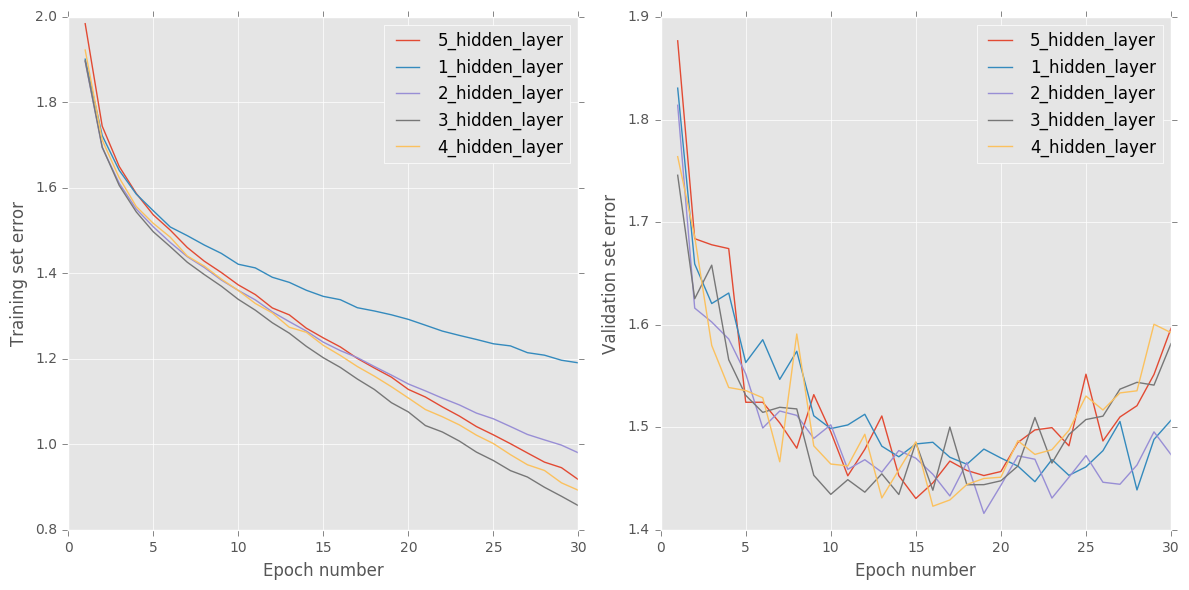

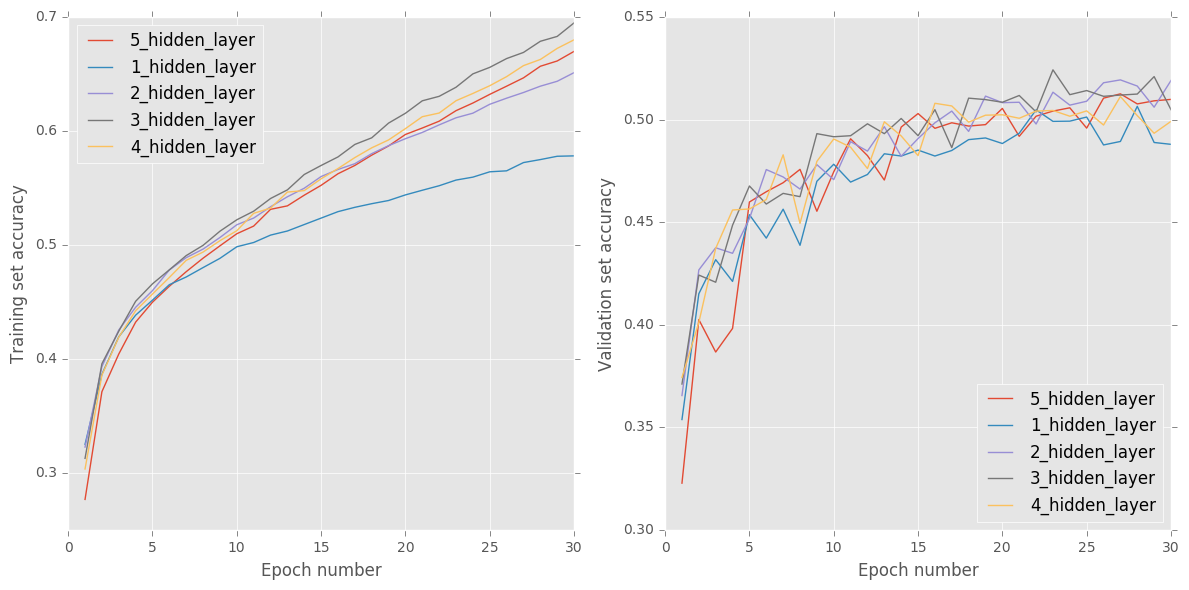

In [16]:
plot_error_and_accuracy(run_info,'Number_of_layers')

### Experiment 5: Training with different activation functions on mulitlayrer network

In [10]:
    run_info = {}
    labels = ['Sigmoid_Layer','Tanh_Layer','ELU_Layer','ReLu_Layer', 'Softplus_Layer']
    num_hidden = 512
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    #Weights and biases
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    # Model Structure
    hidden_1 = tf.nn.sigmoid(tf.matmul(inputs, weights_1) + biases_1)

    hidden_2= tf.nn.sigmoid(tf.matmul(hidden_1, weights_2) + biases_2)

    hidden_3 = tf.nn.sigmoid(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    #Training 
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: Sigmoid_Layer
End of epoch 05: err(train)=1.5218 acc(train)=0.4542
                 err(valid)=1.5341 acc(valid)=0.4523
End of epoch 10: err(train)=1.3816 acc(train)=0.5050
                 err(valid)=1.4422 acc(valid)=0.4915
End of epoch 15: err(train)=1.2888 acc(train)=0.5382
                 err(valid)=1.4783 acc(valid)=0.4795
End of epoch 20: err(train)=1.2053 acc(train)=0.5666
                 err(valid)=1.4084 acc(valid)=0.5064
End of epoch 25: err(train)=1.1229 acc(train)=0.5983
                 err(valid)=1.4308 acc(valid)=0.5050
End of epoch 30: err(train)=1.0555 acc(train)=0.6225
                 err(valid)=1.4652 acc(valid)=0.5022
Min_Validation_Error: 1.40552805215 
Max_Validation_Accuracy: 0.511400000006 


In [11]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    #Weights and biases
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    # Model Structure
    hidden_1 = tf.nn.tanh(tf.matmul(inputs, weights_1) + biases_1)

    hidden_2= tf.nn.tanh(tf.matmul(hidden_1, weights_2) + biases_2)

    hidden_3 = tf.nn.tanh(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    #Training 
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: Tanh_Layer
End of epoch 05: err(train)=1.6370 acc(train)=0.4114
                 err(valid)=1.6423 acc(valid)=0.4121
End of epoch 10: err(train)=1.5434 acc(train)=0.4475
                 err(valid)=1.5917 acc(valid)=0.4297
End of epoch 15: err(train)=1.4851 acc(train)=0.4669
                 err(valid)=1.6489 acc(valid)=0.4230
End of epoch 20: err(train)=1.4476 acc(train)=0.4807
                 err(valid)=1.5344 acc(valid)=0.4565
End of epoch 25: err(train)=1.4149 acc(train)=0.4977
                 err(valid)=1.5481 acc(valid)=0.4568
End of epoch 30: err(train)=1.3797 acc(train)=0.5063
                 err(valid)=1.5162 acc(valid)=0.4630
Min_Validation_Error: 1.51621365905 
Max_Validation_Accuracy: 0.466999999508 


In [12]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    #Weights and biases
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    # Model Structure
    hidden_1 = tf.nn.elu(tf.matmul(inputs, weights_1) + biases_1)

    hidden_2= tf.nn.elu(tf.matmul(hidden_1, weights_2) + biases_2)

    hidden_3 = tf.nn.elu(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    #Training 
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: ELU_Layer
End of epoch 05: err(train)=1.4901 acc(train)=0.4651
                 err(valid)=1.5388 acc(valid)=0.4508
End of epoch 10: err(train)=1.2838 acc(train)=0.5404
                 err(valid)=1.4432 acc(valid)=0.4951
End of epoch 15: err(train)=1.1241 acc(train)=0.5968
                 err(valid)=1.4457 acc(valid)=0.5023
End of epoch 20: err(train)=0.9567 acc(train)=0.6534
                 err(valid)=1.4743 acc(valid)=0.5241
End of epoch 25: err(train)=0.8103 acc(train)=0.7081
                 err(valid)=1.6130 acc(valid)=0.5248
End of epoch 30: err(train)=0.6863 acc(train)=0.7524
                 err(valid)=1.7918 acc(valid)=0.5235
Min_Validation_Error: 1.39414398432 
Max_Validation_Accuracy: 0.530000000894 


In [13]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    #Weights and biases
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    # Model Structure
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)

    hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)

    hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    #Training 
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: ReLu_Layer
End of epoch 05: err(train)=1.5028 acc(train)=0.4632
                 err(valid)=1.5421 acc(valid)=0.4509
End of epoch 10: err(train)=1.3511 acc(train)=0.5190
                 err(valid)=1.4518 acc(valid)=0.4944
End of epoch 15: err(train)=1.2207 acc(train)=0.5615
                 err(valid)=1.4702 acc(valid)=0.4926
End of epoch 20: err(train)=1.0949 acc(train)=0.6065
                 err(valid)=1.4724 acc(valid)=0.4981
End of epoch 25: err(train)=0.9771 acc(train)=0.6514
                 err(valid)=1.5226 acc(valid)=0.4940
End of epoch 30: err(train)=0.8718 acc(train)=0.6863
                 err(valid)=1.5585 acc(valid)=0.5063
Min_Validation_Error: 1.42233949065 
Max_Validation_Accuracy: 0.517699999958 


In [14]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    #Weights and biases
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    # Model Structure
    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)

    hidden_2= tf.nn.softplus(tf.matmul(hidden_1, weights_2) + biases_2)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    #Training 
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: Softplus_Layer
End of epoch 05: err(train)=1.4475 acc(train)=0.4852
                 err(valid)=1.5079 acc(valid)=0.4640
End of epoch 10: err(train)=1.2430 acc(train)=0.5546
                 err(valid)=1.4096 acc(valid)=0.5090
End of epoch 15: err(train)=1.0603 acc(train)=0.6159
                 err(valid)=1.3907 acc(valid)=0.5284
End of epoch 20: err(train)=0.8736 acc(train)=0.6849
                 err(valid)=1.5353 acc(valid)=0.5217
End of epoch 25: err(train)=0.7131 acc(train)=0.7428
                 err(valid)=1.7234 acc(valid)=0.5100
End of epoch 30: err(train)=0.5697 acc(train)=0.7918
                 err(valid)=2.0299 acc(valid)=0.5175
Min_Validation_Error: 1.38175548285 
Max_Validation_Accuracy: 0.531600000411 


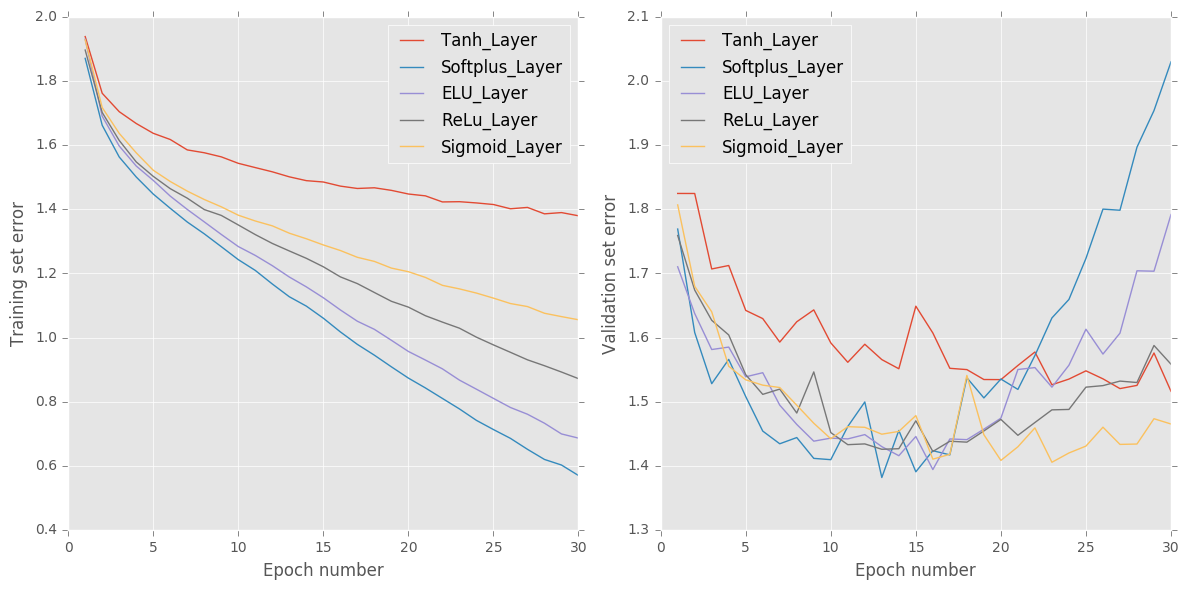

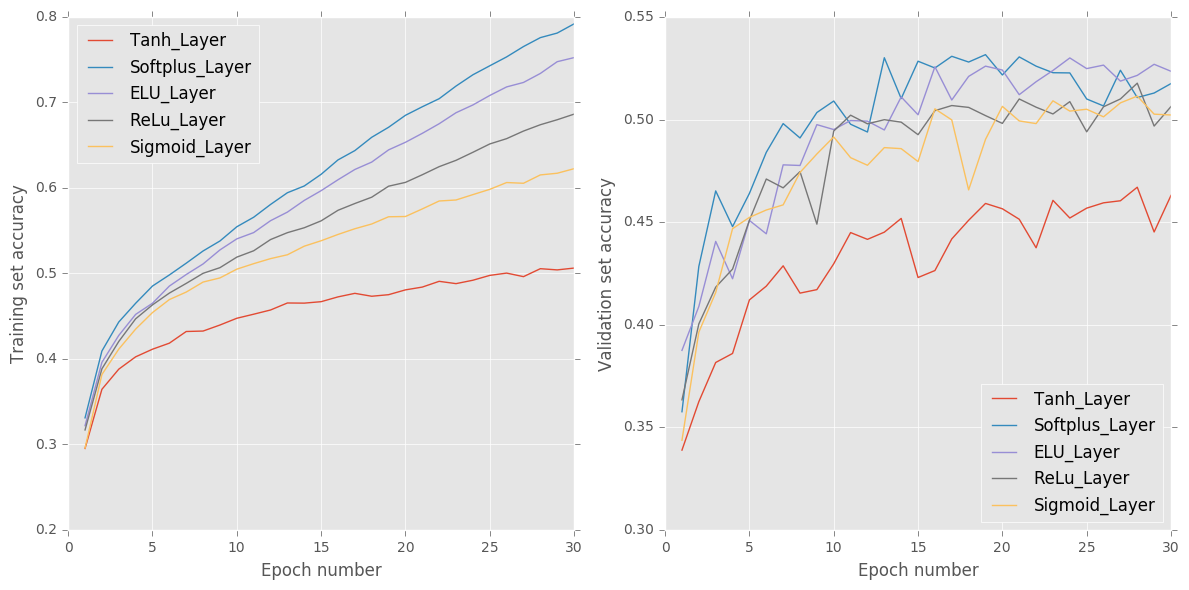

In [15]:
plot_error_and_accuracy(run_info,'Activation_functions_on_3_layer_model')

### Experiment 6: Training with Dropout

In [7]:
    run_info = {}
    num_hidden = 512
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    labels = ['1_hidden_layer','2_hidden_layer','3_hidden_layer','4_hidden_layer','5_hidden_layer']

    tf.reset_default_graph()

    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                    stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, train_data.num_classes], 
                                                    stddev=2. / (num_hidden + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))
    
    #training
    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
  
    outputs = tf.matmul(hidden_1_dropout, weights_2) + biases_2

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_outputs = tf.matmul(v_hidden_1, weights_2) + biases_2
    
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 1_hidden_layer
End of epoch 05: err(train)=1.5490 acc(train)=0.4544
                 err(valid)=1.5545 acc(valid)=0.4607
End of epoch 10: err(train)=1.4211 acc(train)=0.4983
                 err(valid)=1.4813 acc(valid)=0.4824
End of epoch 15: err(train)=1.3292 acc(train)=0.5304
                 err(valid)=1.4467 acc(valid)=0.5009
End of epoch 20: err(train)=1.2527 acc(train)=0.5557
                 err(valid)=1.4320 acc(valid)=0.5096
End of epoch 25: err(train)=1.1768 acc(train)=0.5829
                 err(valid)=1.5289 acc(valid)=0.4883
End of epoch 30: err(train)=1.1150 acc(train)=0.6037
                 err(valid)=1.4570 acc(valid)=0.5193
End of epoch 35: err(train)=1.0597 acc(train)=0.6243
                 err(valid)=1.4967 acc(valid)=0.5132
End of epoch 40: err(train)=1.0067 acc(train)=0.6419
                 err(valid)=1.5248 acc(valid)=0.5200
End of epoch 45: err(train)=0.9579 acc(train)=0.6595
                 err(valid)=1.5580 acc(valid)=0.5219
End of epoch 50: err(tra

In [8]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
   
 
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_1 + train_data.num_classes)**0.5))  
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([train_data.num_classes]))
        

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    outputs = tf.matmul(hidden_2_dropout, weights_3) + biases_3

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    
    v_outputs = tf.matmul(v_hidden_2, weights_3) + biases_3

    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)), tf.float32))

    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 2_hidden_layer
End of epoch 05: err(train)=1.5088 acc(train)=0.4593
                 err(valid)=1.5036 acc(valid)=0.4591
End of epoch 10: err(train)=1.3520 acc(train)=0.5158
                 err(valid)=1.3951 acc(valid)=0.5110
End of epoch 15: err(train)=1.2259 acc(train)=0.5617
                 err(valid)=1.3516 acc(valid)=0.5233
End of epoch 20: err(train)=1.1237 acc(train)=0.5933
                 err(valid)=1.3595 acc(valid)=0.5339
End of epoch 25: err(train)=1.0268 acc(train)=0.6259
                 err(valid)=1.3655 acc(valid)=0.5368
End of epoch 30: err(train)=0.9461 acc(train)=0.6557
                 err(valid)=1.4138 acc(valid)=0.5383
End of epoch 35: err(train)=0.8692 acc(train)=0.6858
                 err(valid)=1.4761 acc(valid)=0.5257
End of epoch 40: err(train)=0.8097 acc(train)=0.7068
                 err(valid)=1.4912 acc(valid)=0.5332
End of epoch 45: err(train)=0.7552 acc(train)=0.7244
                 err(valid)=1.5572 acc(valid)=0.5358
End of epoch 50: err(tra

In [9]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 3_hidden_layer
End of epoch 05: err(train)=1.5398 acc(train)=0.4469
                 err(valid)=1.5242 acc(valid)=0.4535
End of epoch 10: err(train)=1.3814 acc(train)=0.5035
                 err(valid)=1.4030 acc(valid)=0.5011
End of epoch 15: err(train)=1.2566 acc(train)=0.5471
                 err(valid)=1.3544 acc(valid)=0.5210
End of epoch 20: err(train)=1.1527 acc(train)=0.5842
                 err(valid)=1.3659 acc(valid)=0.5212
End of epoch 25: err(train)=1.0612 acc(train)=0.6163
                 err(valid)=1.3714 acc(valid)=0.5348
End of epoch 30: err(train)=0.9816 acc(train)=0.6411
                 err(valid)=1.4008 acc(valid)=0.5347
End of epoch 35: err(train)=0.9078 acc(train)=0.6697
                 err(valid)=1.4295 acc(valid)=0.5430
End of epoch 40: err(train)=0.8507 acc(train)=0.6909
                 err(valid)=1.4839 acc(valid)=0.5448
End of epoch 45: err(train)=0.7966 acc(train)=0.7066
                 err(valid)=1.5550 acc(valid)=0.5416
End of epoch 50: err(tra

In [10]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")

    

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_3 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([train_data.num_classes]))
            

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)
    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    hidden_4 = tf.nn.softplus(tf.matmul(hidden_3_dropout, weights_4) + biases_4)
    hidden_4_dropout = tf.nn.dropout(hidden_4, prob)
    outputs = tf.matmul(hidden_4_dropout, weights_5) + biases_5

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2 = tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)
    v_hidden_4 = tf.nn.softplus(tf.matmul(v_hidden_3, weights_4) + biases_4)  
    
    v_outputs = tf.matmul(v_hidden_4, weights_5) + biases_5


    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 4_hidden_layer
End of epoch 05: err(train)=1.5712 acc(train)=0.4373
                 err(valid)=1.5386 acc(valid)=0.4477
End of epoch 10: err(train)=1.4047 acc(train)=0.4951
                 err(valid)=1.4094 acc(valid)=0.5013
End of epoch 15: err(train)=1.2908 acc(train)=0.5351
                 err(valid)=1.3685 acc(valid)=0.5173
End of epoch 20: err(train)=1.1881 acc(train)=0.5726
                 err(valid)=1.3634 acc(valid)=0.5274
End of epoch 25: err(train)=1.1101 acc(train)=0.6006
                 err(valid)=1.3229 acc(valid)=0.5419
End of epoch 30: err(train)=1.0308 acc(train)=0.6269
                 err(valid)=1.3593 acc(valid)=0.5448
End of epoch 35: err(train)=0.9646 acc(train)=0.6488
                 err(valid)=1.3839 acc(valid)=0.5407
End of epoch 40: err(train)=0.9006 acc(train)=0.6744
                 err(valid)=1.4428 acc(valid)=0.5408
End of epoch 45: err(train)=0.8473 acc(train)=0.6919
                 err(valid)=1.4984 acc(valid)=0.5317
End of epoch 50: err(tra

In [11]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                      stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
    biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2 = tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)
    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    hidden_4 = tf.nn.softplus(tf.matmul(hidden_3_dropout, weights_4) + biases_4)
    hidden_4_dropout = tf.nn.dropout(hidden_4, prob)
    hidden_5 = tf.nn.softplus(tf.matmul(hidden_4_dropout, weights_5) + biases_5)
    hidden_5_dropout = tf.nn.dropout(hidden_5, prob)
    outputs = tf.matmul(hidden_5_dropout, weights_6) + biases_6
    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2 = tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)
    v_hidden_4 = tf.nn.softplus(tf.matmul(v_hidden_3, weights_4) + biases_4)
    v_hidden_5 = tf.nn.softplus(tf.matmul(v_hidden_4, weights_5) + biases_5)  
    v_outputs = tf.matmul(v_hidden_5, weights_6) + biases_6

    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))
    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 5_hidden_layer
End of epoch 05: err(train)=1.6358 acc(train)=0.4139
                 err(valid)=1.5743 acc(valid)=0.4426
End of epoch 10: err(train)=1.4701 acc(train)=0.4739
                 err(valid)=1.4599 acc(valid)=0.4879
End of epoch 15: err(train)=1.3601 acc(train)=0.5148
                 err(valid)=1.3940 acc(valid)=0.5083
End of epoch 20: err(train)=1.2608 acc(train)=0.5484
                 err(valid)=1.3814 acc(valid)=0.5154
End of epoch 25: err(train)=1.1775 acc(train)=0.5799
                 err(valid)=1.3745 acc(valid)=0.5163
End of epoch 30: err(train)=1.1022 acc(train)=0.6067
                 err(valid)=1.3712 acc(valid)=0.5347
End of epoch 35: err(train)=1.0334 acc(train)=0.6282
                 err(valid)=1.3903 acc(valid)=0.5376
End of epoch 40: err(train)=0.9733 acc(train)=0.6519
                 err(valid)=1.4285 acc(valid)=0.5444
End of epoch 45: err(train)=0.9081 acc(train)=0.6738
                 err(valid)=1.4602 acc(valid)=0.5335
End of epoch 50: err(tra

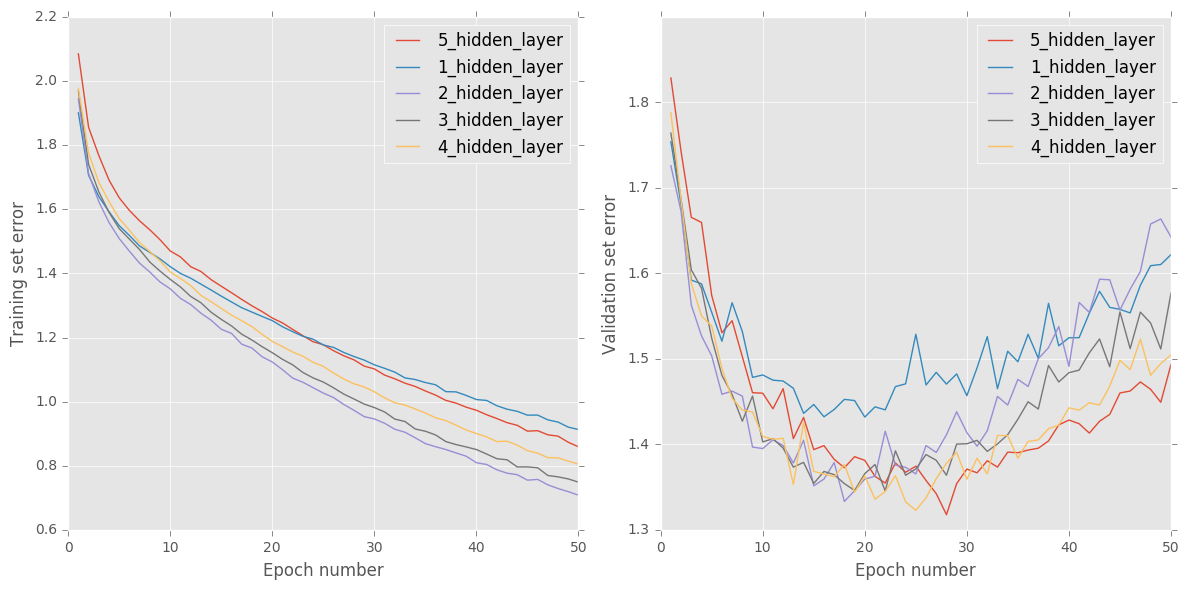

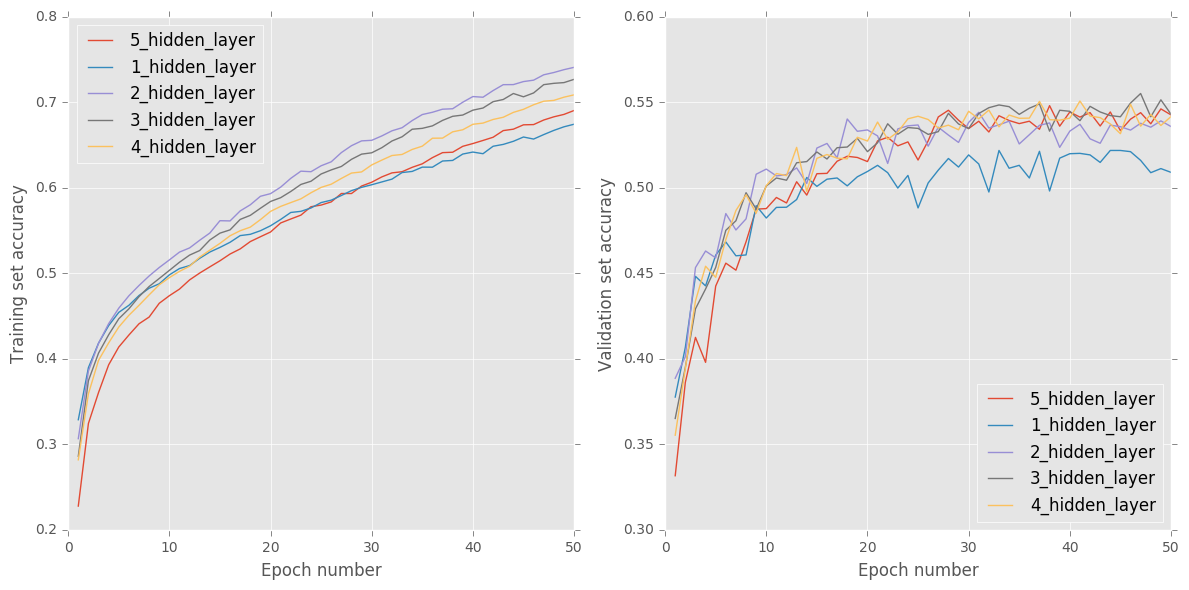

In [13]:
plot_error_and_accuracy(run_info,'Number_of_layers_with_Dropout')

In [7]:
    run_info = {}
    num_hidden = 2048
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                      stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
    biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2 = tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)
    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    hidden_4 = tf.nn.softplus(tf.matmul(hidden_3_dropout, weights_4) + biases_4)
    hidden_4_dropout = tf.nn.dropout(hidden_4, prob)
    hidden_5 = tf.nn.softplus(tf.matmul(hidden_4_dropout, weights_5) + biases_5)
    hidden_5_dropout = tf.nn.dropout(hidden_5, prob)
    outputs = tf.matmul(hidden_5_dropout, weights_6) + biases_6
    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2 = tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)
    v_hidden_4 = tf.nn.softplus(tf.matmul(v_hidden_3, weights_4) + biases_4)
    v_hidden_5 = tf.nn.softplus(tf.matmul(v_hidden_4, weights_5) + biases_5)  
    v_outputs = tf.matmul(v_hidden_5, weights_6) + biases_6

    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))
    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format('5_layer_extended'))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info['5_layer_extended'] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 5_layer_extended
End of epoch 05: err(train)=1.5380 acc(train)=0.4475
                 err(valid)=1.5401 acc(valid)=0.4474
End of epoch 10: err(train)=1.3382 acc(train)=0.5187
                 err(valid)=1.3813 acc(valid)=0.5104
End of epoch 15: err(train)=1.1601 acc(train)=0.5791
                 err(valid)=1.3432 acc(valid)=0.5380
End of epoch 20: err(train)=0.9716 acc(train)=0.6477
                 err(valid)=1.4154 acc(valid)=0.5385
End of epoch 25: err(train)=0.7973 acc(train)=0.7050
                 err(valid)=1.5327 acc(valid)=0.5419
End of epoch 30: err(train)=0.6409 acc(train)=0.7661
                 err(valid)=1.7030 acc(valid)=0.5406
End of epoch 35: err(train)=0.5350 acc(train)=0.8055
                 err(valid)=1.8531 acc(valid)=0.5400
End of epoch 40: err(train)=0.4565 acc(train)=0.8358
                 err(valid)=2.0154 acc(valid)=0.5304
End of epoch 45: err(train)=0.4009 acc(train)=0.8597
                 err(valid)=2.1641 acc(valid)=0.5385
End of epoch 50: err(t

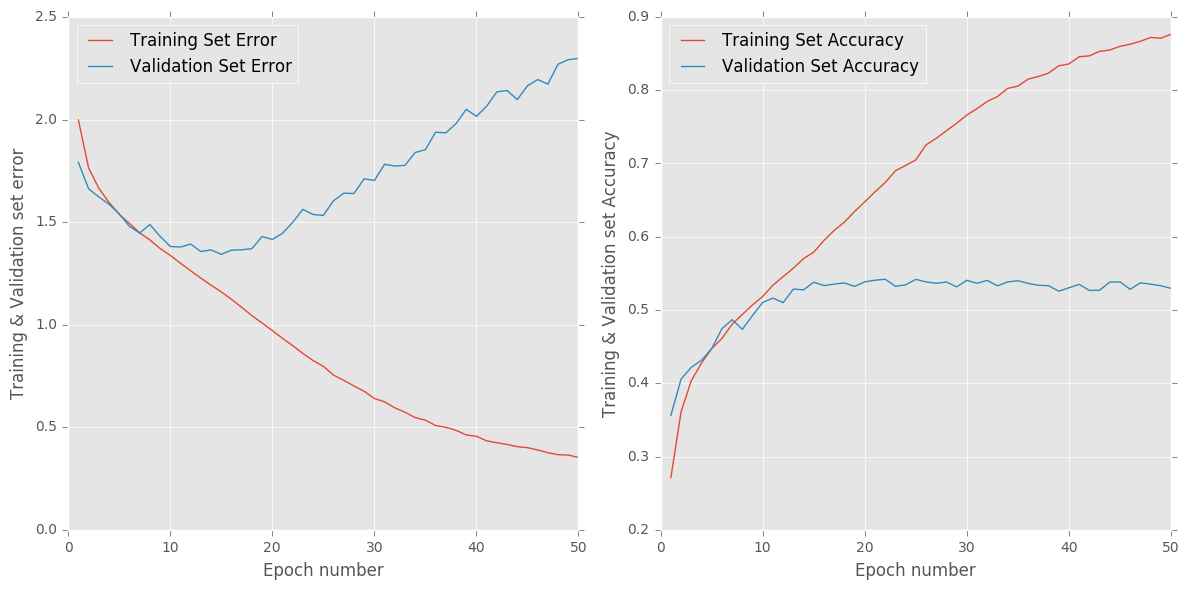

In [9]:
plot_error_and_accuracy_single(run_info, '5_layer_wDropout_extended')

In [7]:
run_info = {}
num_hidden = 512
num_hidden_1 = int(num_hidden * 0.5)
num_hidden_2 = int(num_hidden_1 * 0.5)
num_hidden_3 = int(num_hidden_2 * 0.5)
num_hidden_4 = int(num_hidden_3 * 0.5)
labels = ['prob_0.1','prob_0.3','prob_0.5','prob_0.7','prob_0.9']
kept_probs = [0.1, 0.3, 0.5, 0.7, 0.9]

for kept_prob, label in zip(kept_probs, labels):
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(label))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: kept_prob})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: prob_0.1
End of epoch 05: err(train)=2.3198 acc(train)=0.0988
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 10: err(train)=2.3049 acc(train)=0.0973
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 15: err(train)=2.3050 acc(train)=0.0961
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 20: err(train)=2.3051 acc(train)=0.0973
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 25: err(train)=2.3073 acc(train)=0.0979
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 30: err(train)=2.3040 acc(train)=0.0980
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 35: err(train)=2.3036 acc(train)=0.0984
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 40: err(train)=2.3052 acc(train)=0.0992
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 45: err(train)=2.3033 acc(train)=0.0978
                 err(valid)=2.3026 acc(valid)=0.1000
End of epoch 50: err(train)=2.

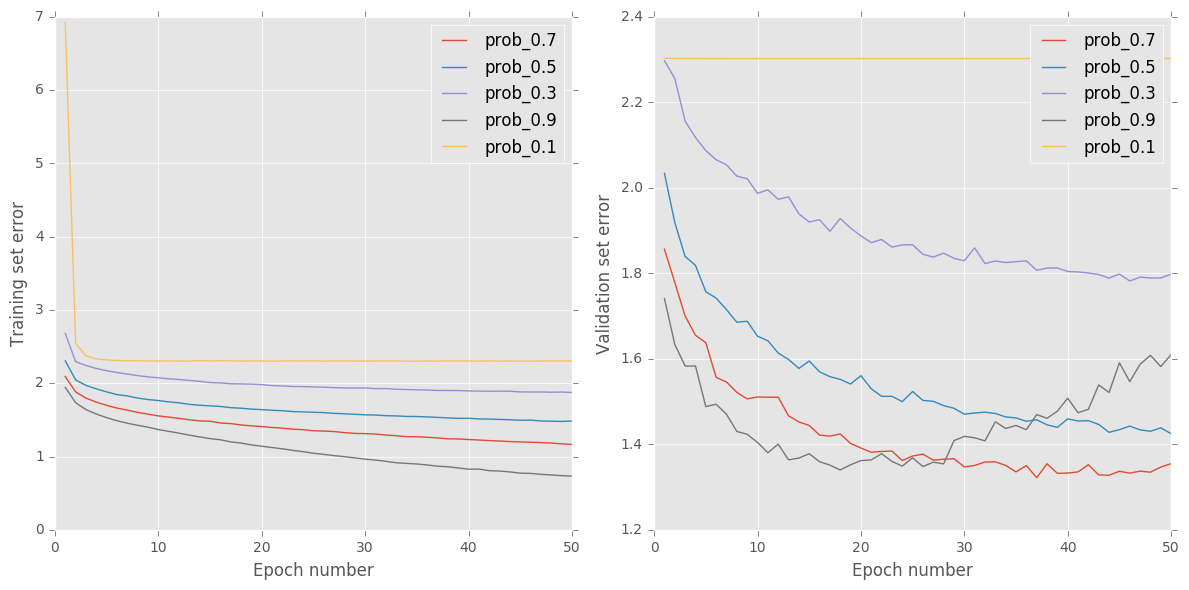

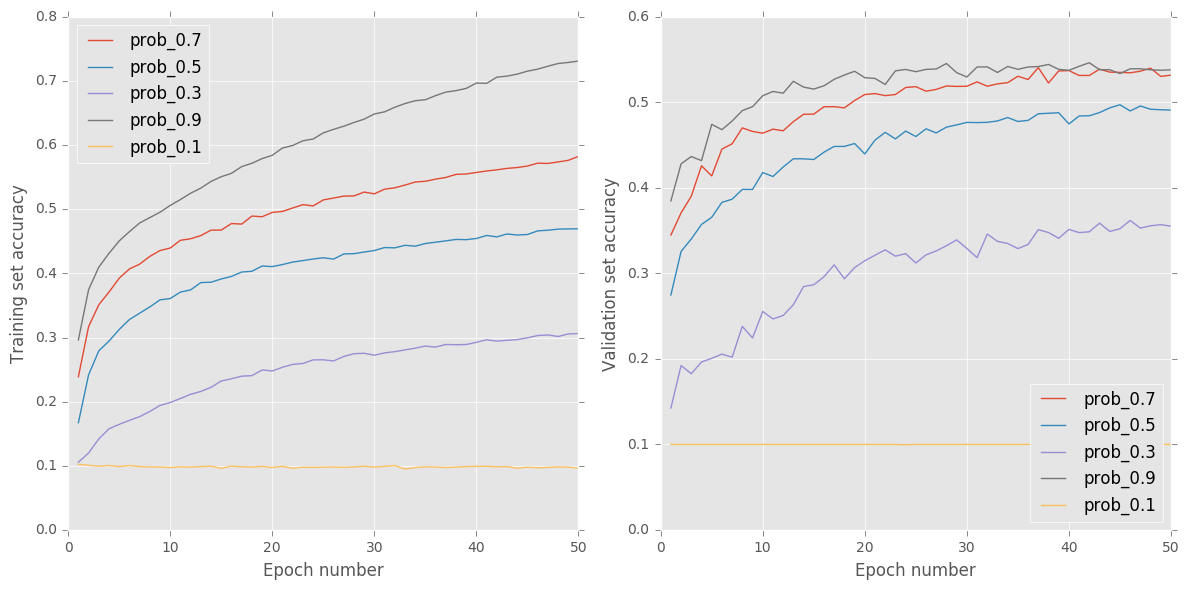

In [8]:
plot_error_and_accuracy(run_info, '3_layers_wDropout_over_probs')

### Experiment 7: Training with regularization and dropout on the layer model over L2 penalty values

In [12]:
run_info = {}
num_hidden = 512
num_hidden_1 = int(num_hidden * 0.5)
num_hidden_2 = int(num_hidden_1 * 0.5)
num_hidden_3 = int(num_hidden_2 * 0.5)
num_hidden_4 = int(num_hidden_3 * 0.5)
labels = ['L2_penalty: 0.01','L2_penalty: 0.001','L2_penalty: 0.0001','L2_penalty: 0.00001']
lambdas = [0.01,0.001,0.0001,0.00001]

for l, label in zip(lambdas, labels):
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    regularizers = tf.reduce_sum(tf.square(weights_1)) + tf.reduce_sum(tf.square(weights_2)) + tf.reduce_sum(tf.square(weights_3)) + tf.reduce_sum(tf.square(weights_4))
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets) + l * regularizers)
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(label))
        for e in range(80):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: L2_penalty: 0.01
End of epoch 05: err(train)=2.1604 acc(train)=0.2540
                 err(valid)=1.9485 acc(valid)=0.2898
End of epoch 10: err(train)=2.1405 acc(train)=0.2551
                 err(valid)=1.9355 acc(valid)=0.2855
End of epoch 15: err(train)=2.1390 acc(train)=0.2555
                 err(valid)=1.9304 acc(valid)=0.2967
End of epoch 20: err(train)=2.1314 acc(train)=0.2597
                 err(valid)=1.9439 acc(valid)=0.2559
End of epoch 25: err(train)=2.1284 acc(train)=0.2604
                 err(valid)=1.9436 acc(valid)=0.2775
End of epoch 30: err(train)=2.1239 acc(train)=0.2612
                 err(valid)=1.9373 acc(valid)=0.2754
End of epoch 35: err(train)=2.1285 acc(train)=0.2630
                 err(valid)=1.9656 acc(valid)=0.2604
End of epoch 40: err(train)=2.1255 acc(train)=0.2617
                 err(valid)=1.9210 acc(valid)=0.2797
End of epoch 45: err(train)=2.1234 acc(train)=0.2629
                 err(valid)=1.9148 acc(valid)=0.2904
End of epoch 50: err(t

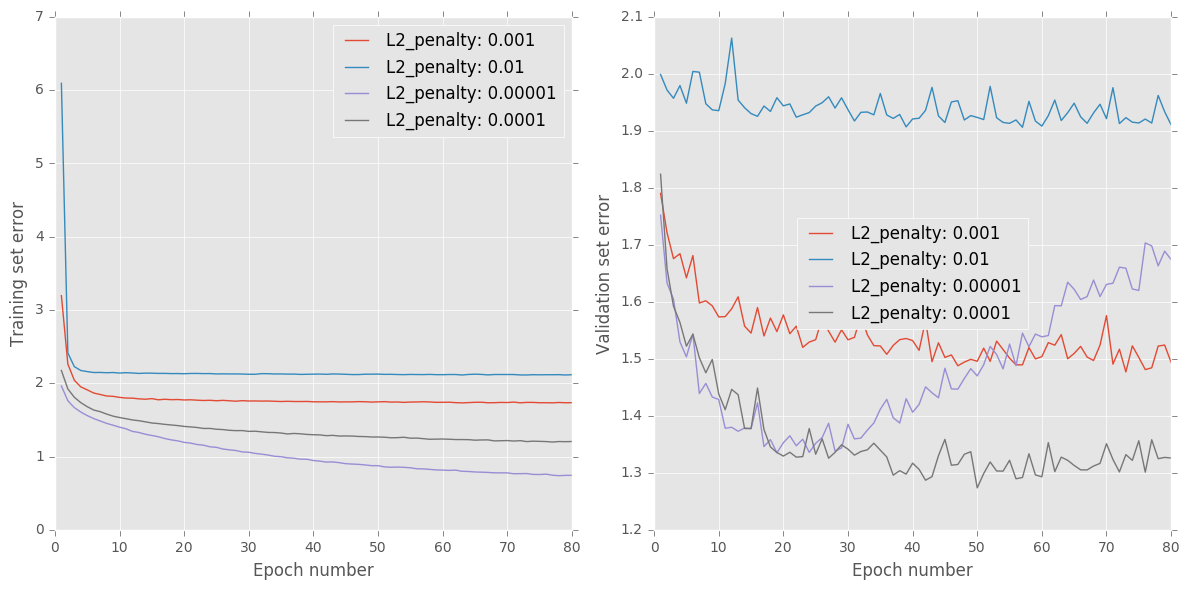

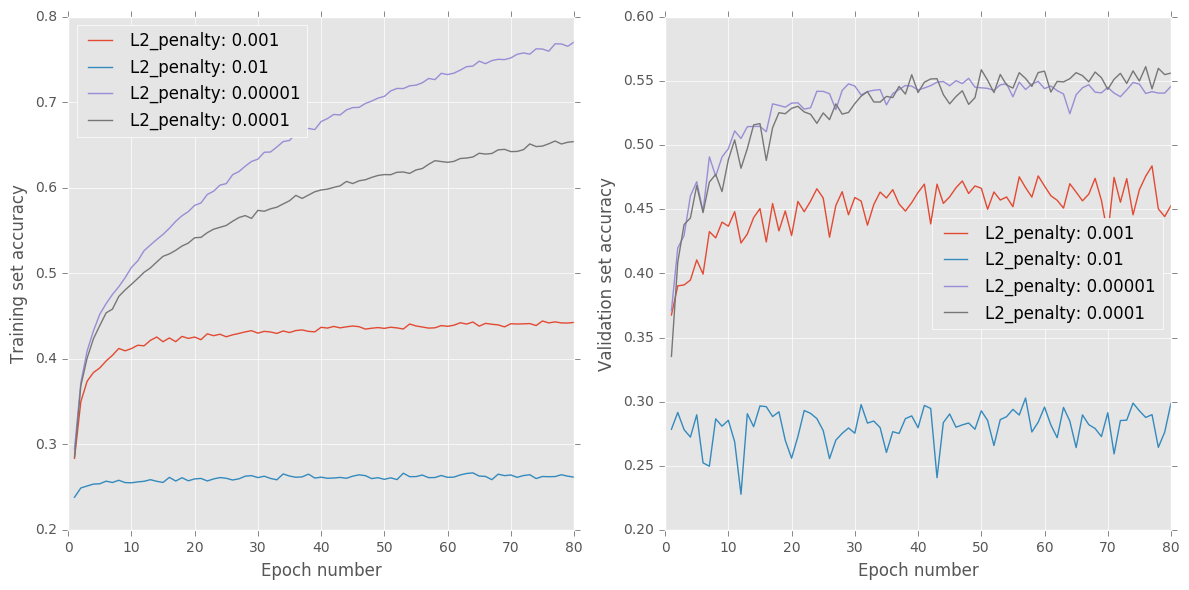

In [13]:
plot_error_and_accuracy(run_info, '3_layers_wL2_wDropout_over_L2param')

### Experiment 8: Training with Batch Normalization

In [62]:
# modified from source: http://r2rt.com/implementing-batch-normalization-in-tensorflow.html 
def batchNormWrapper(inputs, is_training, epsilon = 1e-3, decay=0.999):
    outputDim = inputs.get_shape()[-1]

    pop_mean = tf.Variable(tf.zeros(inputs.get_shape()[-1]), trainable=False)
    pop_var = tf.Variable(tf.ones(inputs.get_shape()[-1]), trainable=False)

    beta = tf.Variable(tf.zeros(inputs.get_shape()[-1]))
    gamma = tf.Variable(tf.ones(inputs.get_shape()[-1]))

    #given that on axis=0 is where the batches extend (we want mean and var for each attribute)
    batch_mean, batch_var = tf.nn.moments(inputs,[0])
    mean = tf.assign(pop_mean, pop_mean*decay+batch_mean*(1-decay))
    var = tf.assign(pop_var, pop_var*decay+batch_var*(1-decay))
    
    with tfcontrol_dependencies([mean, var]):
        output = tf.nn.batch_normalization(inputs, tf.cond(is_training, lambda:batch_mean, lambda: pop_mean,
                                                    tf.cond(is_training, lambda:batch_var, lambda: var),
                                                    betat, gamma, epsilon)

    return output

In [8]:
    run_info = {}
    num_hidden = 512
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    labels = ['1_hidden_layer','2_hidden_layer','3_hidden_layer','4_hidden_layer','5_hidden_layer']
    epsilon = 1e-3
    tf.reset_default_graph()

    
    def build_graph(is_training):
        train_data.reset()
        valid_data.reset()
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        is_training = tf.placeholder(tf.bool, name='is_training')

        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                        stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, train_data.num_classes], 
                                                        stddev=2. / (num_hidden + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))

        affine = tf.matmul(inputs, weights_1) + biases_1
        batch = batchNormWrapper(affine, is_training)

        hidden_1 = tf.nn.softplus(batch)

        outputs = tf.matmul(hidden_1, weights_2) + biases_2

        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))    
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
        return (inputs, targets), train_step, accuracy, error, outputs, tf.train.Saver()
    
    
    
    (inputs, targets), train_step, accuracy, error, _, saver = build_graph(is_training=True)
    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: True})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        saved_model = saver.save(sess, 'temp-bn-save')

Model: 1_hidden_layer
End of epoch 05: err(train)=1.4448 acc(train)=0.4963
                 err(valid)=1.5398 acc(valid)=0.4621
End of epoch 10: err(train)=1.2731 acc(train)=0.5545
                 err(valid)=1.4670 acc(valid)=0.4857
End of epoch 15: err(train)=1.1410 acc(train)=0.5987
                 err(valid)=1.4541 acc(valid)=0.4972
End of epoch 20: err(train)=1.0262 acc(train)=0.6427
                 err(valid)=1.4869 acc(valid)=0.5055
End of epoch 25: err(train)=0.9224 acc(train)=0.6798
                 err(valid)=1.5352 acc(valid)=0.5026
End of epoch 30: err(train)=0.8270 acc(train)=0.7122
                 err(valid)=1.5587 acc(valid)=0.5197
End of epoch 35: err(train)=0.7400 acc(train)=0.7447
                 err(valid)=1.6054 acc(valid)=0.5133
End of epoch 40: err(train)=0.6555 acc(train)=0.7730
                 err(valid)=1.7346 acc(valid)=0.4994
End of epoch 45: err(train)=0.5780 acc(train)=0.7984
                 err(valid)=1.8390 acc(valid)=0.4922
End of epoch 50: err(tra

In [9]:
    epsilon = 1e-3
    tf.reset_default_graph()
    def build_graph(is_training):
        train_data.reset()
        valid_data.reset()
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        is_training = tf.placeholder(tf.bool, name='is_training')
 
        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                          stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                            stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, train_data.num_classes], 
                                                          stddev=2. / (num_hidden_1 + train_data.num_classes)**0.5))  
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([train_data.num_classes]))


        affine_1 = tf.matmul(inputs, weights_1) + biases_1
        batch_1 = batcNormWrapper(affine_1, is_training) 
        hidden_1 = tf.nn.softplus(batch_1)

        affine_2 = tf.matmul(hidden_1, weights_2) + biases_2
        batch_2 = batcNormWrapper(affine_2, is_training)
        hidden_2= tf.nn.softplus(batch_2)


        outputs = tf.matmul(hidden_2, weights_3) + biases_3

        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))

        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

        return (inputs, targets), train_step, accuracy, error, outputs, tf.train.Saver()
    
    
    
    (inputs, targets), train_step, accuracy, error, _, saver = build_graph(is_training=True)
    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: True})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))

            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        saved_model = saver.save(sess, 'temp-bn-save')

Model: 2_hidden_layer
End of epoch 05: err(train)=1.3331 acc(train)=0.5294
                 err(valid)=1.4459 acc(valid)=0.4968
End of epoch 10: err(train)=1.1268 acc(train)=0.6029
                 err(valid)=1.3869 acc(valid)=0.5205
End of epoch 15: err(train)=0.9618 acc(train)=0.6617
                 err(valid)=1.4248 acc(valid)=0.5187
End of epoch 20: err(train)=0.8089 acc(train)=0.7134
                 err(valid)=1.4797 acc(valid)=0.5287
End of epoch 25: err(train)=0.6584 acc(train)=0.7694
                 err(valid)=1.6191 acc(valid)=0.5182
End of epoch 30: err(train)=0.5400 acc(train)=0.8089
                 err(valid)=1.7561 acc(valid)=0.5201
End of epoch 35: err(train)=0.4409 acc(train)=0.8466
                 err(valid)=1.9384 acc(valid)=0.5124
End of epoch 40: err(train)=0.3607 acc(train)=0.8746
                 err(valid)=2.1568 acc(valid)=0.5044
End of epoch 45: err(train)=0.2994 acc(train)=0.8965
                 err(valid)=2.2329 acc(valid)=0.5080
End of epoch 50: err(tra

In [10]:
    epsilon = 1e-3
    tf.reset_default_graph()
    def build_graph(is_training):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        is_training = tf.placeholder(tf.bool, name='is_training')


        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                          stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                            stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                            stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
        weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                          stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
        biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

        affine_1 = tf.matmul(inputs, weights_1) + biases_1
        batch_1 = batcNormWrapper(affine_1, is_training) 
        hidden_1 = tf.nn.softplus(batch_1)

        affine_2 = tf.matmul(hidden_1, weights_2) + biases_2
        batch_2 = batcNormWrapper(affine_2, is_training)
        hidden_2= tf.nn.softplus(batch_2)

        affine_3 = tf.matmul(hidden_2, weights_3) + biases_3
        batch_3 = batcNormWrapper(affine_3, is_training)
        hidden_3 = tf.nn.softplus(batch_3)


        outputs = tf.matmul(hidden_3, weights_4) + biases_4


        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))

        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
        return (inputs, targets), train_step, accuracy, error, outputs, tf.train.Saver()


    
    (inputs, targets), train_step, accuracy, error, _, saver = build_graph(is_training=True)
    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, istraining: True})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        saved_model = saver.save(sess, 'temp-bn-save')

Model: 3_hidden_layer
End of epoch 05: err(train)=1.2955 acc(train)=0.5395
                 err(valid)=1.4140 acc(valid)=0.5065
End of epoch 10: err(train)=1.0755 acc(train)=0.6180
                 err(valid)=1.3983 acc(valid)=0.5186
End of epoch 15: err(train)=0.8918 acc(train)=0.6848
                 err(valid)=1.4883 acc(valid)=0.5132
End of epoch 20: err(train)=0.7252 acc(train)=0.7425
                 err(valid)=1.5962 acc(valid)=0.5120
End of epoch 25: err(train)=0.5833 acc(train)=0.7939
                 err(valid)=1.7511 acc(valid)=0.5068
End of epoch 30: err(train)=0.4704 acc(train)=0.8342
                 err(valid)=1.9319 acc(valid)=0.5072
End of epoch 35: err(train)=0.3805 acc(train)=0.8653
                 err(valid)=2.0814 acc(valid)=0.5115
End of epoch 40: err(train)=0.3186 acc(train)=0.8887
                 err(valid)=2.2473 acc(valid)=0.5020
End of epoch 45: err(train)=0.2634 acc(train)=0.9063
                 err(valid)=2.4044 acc(valid)=0.5071
End of epoch 50: err(tra

In [11]:
    epsilon = 1e-3
    tf.reset_default_graph()
    
    def build_graph(is_training):
        train_data.reset()
        valid_data.reset()
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        train_phase = tf.placeholder(tf.bool, name='train_phase')
        is_training = tf.placeholder(tf.bool, name='is_training')



        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                          stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                            stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                            stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
        weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                          stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
        weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, train_data.num_classes], 
                                                          stddev=2. / (num_hidden_3 + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
        biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
        biases_5 = tf.Variable(tf.zeros([train_data.num_classes]))
        
        affine_1 = tf.matmul(inputs, weights_1) + biases_1
        batch_1 = batcNormWrapper(affine_1, is_training) 
        hidden_1 = tf.nn.softplus(batch_1)

        affine_2 = tf.matmul(hidden_1, weights_2) + biases_2
        batch_2 = batcNormWrapper(affine_2, is_training)
        hidden_2= tf.nn.softplus(batch_2)

        affine_3 = tf.matmul(hidden_2, weights_3) + biases_3
        batch_3 = batcNormWrapper(affine_3, is_training)
        hidden_3 = tf.nn.softplus(batch_3)
        
        affine_4 = tf.matmul(hidden_3, weights_4) + biases_4
        batch_4 = batcNormWrapper(affine_4, is_training)
        hidden_4 = tf.nn.softplus(batch_4)

        outputs = tf.matmul(hidden_4, weights_5) + biases_5

        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
        return (inputs, targets), train_step, accuracy, error, outputs, tf.train.Saver()

    
    (inputs, targets), train_step, accuracy, error, _, saver = build_graph(is_training=True)
    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: True})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        saved_model = saver.save(sess, 'temp-bn-save')

Model: 4_hidden_layer
End of epoch 05: err(train)=1.2812 acc(train)=0.5450
                 err(valid)=1.4119 acc(valid)=0.5016
End of epoch 10: err(train)=1.0732 acc(train)=0.6149
                 err(valid)=1.3870 acc(valid)=0.5193
End of epoch 15: err(train)=0.8936 acc(train)=0.6794
                 err(valid)=1.4295 acc(valid)=0.5259
End of epoch 20: err(train)=0.7309 acc(train)=0.7398
                 err(valid)=1.5843 acc(valid)=0.5167
End of epoch 25: err(train)=0.5933 acc(train)=0.7886
                 err(valid)=1.7417 acc(valid)=0.5144
End of epoch 30: err(train)=0.4835 acc(train)=0.8270
                 err(valid)=1.8534 acc(valid)=0.5207
End of epoch 35: err(train)=0.3984 acc(train)=0.8572
                 err(valid)=2.0538 acc(valid)=0.5130
End of epoch 40: err(train)=0.3387 acc(train)=0.8793
                 err(valid)=2.2639 acc(valid)=0.5066
End of epoch 45: err(train)=0.2773 acc(train)=0.9019
                 err(valid)=2.4257 acc(valid)=0.5069
End of epoch 50: err(tra

In [12]:
    epsilon = 1e-3
    tf.reset_default_graph()
    
    def build_graph(is_training):
       
        train_data.reset()
        valid_data.reset()
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        train_phase = tf.placeholder(tf.bool, name='train_phase')
        is_training = tf.placeholder(tf.bool, name='is_training')

        weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                          stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
        weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                            stddev=2. / (num_hidden + num_hidden_1)**0.5))
        weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                            stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
        weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                          stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
        weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                          stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
        weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                          stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
        biases_1 = tf.Variable(tf.zeros([num_hidden]))
        biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
        biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
        biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
        biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
        biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
        
        affine_1 = tf.matmul(inputs, weights_1) + biases_1
        batch_1 = batcNormWrapper(affine_1, is_training) 
        hidden_1 = tf.nn.softplus(batch_1)

        affine_2 = tf.matmul(hidden_1, weights_2) + biases_2
        batch_2 = batcNormWrapper(affine_2, is_training)
        hidden_2= tf.nn.softplus(batch_2)

        affine_3 = tf.matmul(hidden_2, weights_3) + biases_3
        batch_3 = batcNormWrapper(affine_3, is_training)
        hidden_3 = tf.nn.softplus(batch_3)
        
        affine_4 = tf.matmul(hidden_3, weights_4) + biases_4
        batch_4 = batcNormWrapper(affine_4, is_training)
        hidden_4 = tf.nn.softplus(batch_4)
        
        affine_5 = tf.matmul(hidden_4, weights_5) + biases_5
        batch_5 = batcNormWrapper(affine_5, is_training)
        hidden_5 = tf.nn.softplus(batch_5)
        
        outputs = tf.matmul(hidden_5, weights_6) + biases_6

        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))


        train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
        return (inputs, targets), train_step, accuracy, error, outputs, tf.train.Saver()

    
    (inputs, targets), train_step, accuracy, error, _, saver = build_graph(is_training=True)
    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(50):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: True})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, is_training: False})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        saved_model = saver.save(sess, 'temp-bn-save')

Model: 5_hidden_layer
End of epoch 05: err(train)=1.2902 acc(train)=0.5432
                 err(valid)=1.3977 acc(valid)=0.5079
End of epoch 10: err(train)=1.0821 acc(train)=0.6119
                 err(valid)=1.4152 acc(valid)=0.5097
End of epoch 15: err(train)=0.9172 acc(train)=0.6741
                 err(valid)=1.4392 acc(valid)=0.5234
End of epoch 20: err(train)=0.7581 acc(train)=0.7273
                 err(valid)=1.5677 acc(valid)=0.5123
End of epoch 25: err(train)=0.6267 acc(train)=0.7752
                 err(valid)=1.6971 acc(valid)=0.5130
End of epoch 30: err(train)=0.5139 acc(train)=0.8161
                 err(valid)=1.8566 acc(valid)=0.5174
End of epoch 35: err(train)=0.4301 acc(train)=0.8464
                 err(valid)=2.0375 acc(valid)=0.5095
End of epoch 40: err(train)=0.3677 acc(train)=0.8692
                 err(valid)=2.1402 acc(valid)=0.5138
End of epoch 45: err(train)=0.3152 acc(train)=0.8878
                 err(valid)=2.2890 acc(valid)=0.5066
End of epoch 50: err(tra

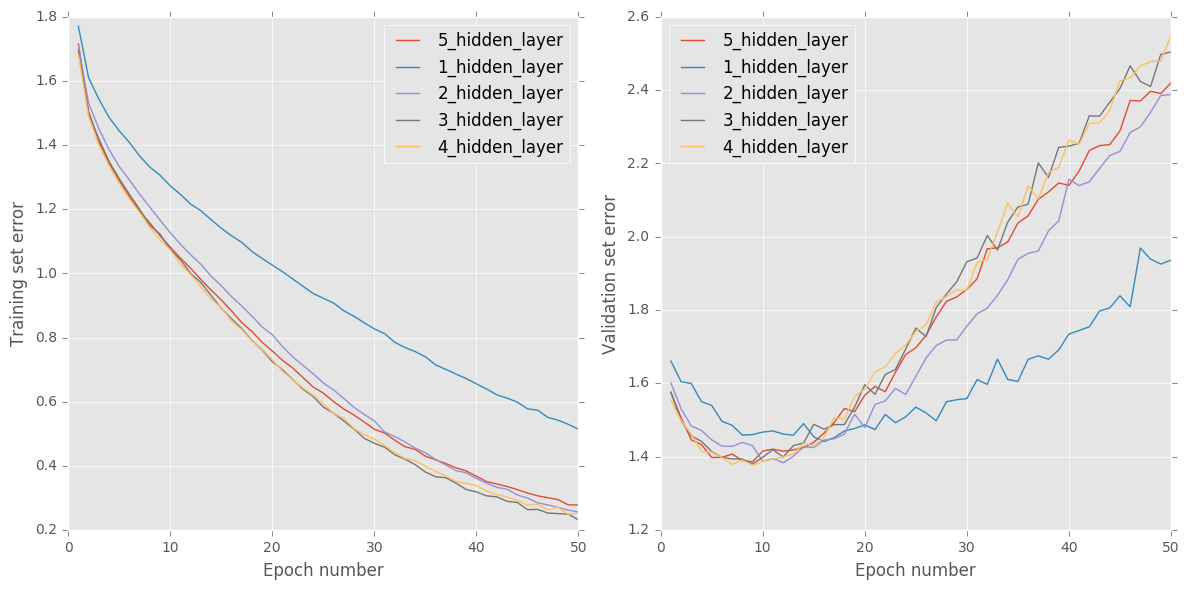

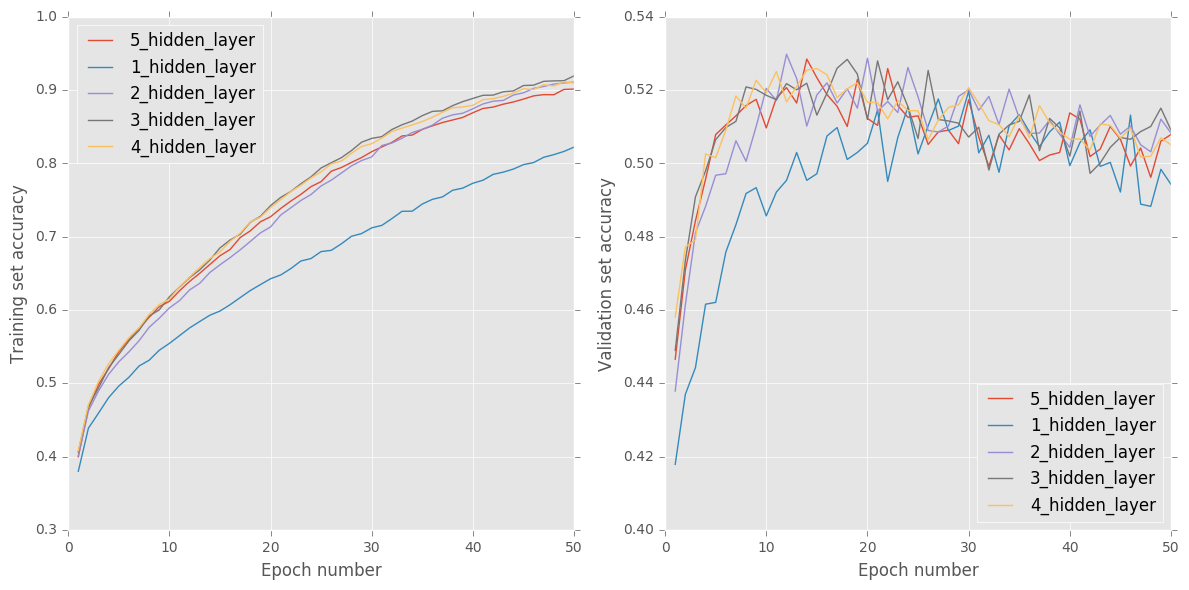

In [13]:
plot_error_and_accuracy(run_info,'Number_of_layers_with_Batch_Normalization')

### Experiment 9: Training with different learning rates 

In [7]:
run_info = {}
num_hidden = 512
num_hidden_1 = int(num_hidden * 0.5)
num_hidden_2 = int(num_hidden_1 * 0.5)
num_hidden_3 = int(num_hidden_2 * 0.5)
num_hidden_4 = int(num_hidden_3 * 0.5)
labels = ['0.001','0.0005','0.0001','0.00005','0.00001']
l_rates = [0.001,0.0005,0.0001,0.00005,0.00001]

for l, label in zip(l_rates, labels):
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    regularizers = tf.reduce_sum(tf.square(weights_1)) + tf.reduce_sum(tf.square(weights_2)) + tf.reduce_sum(tf.square(weights_3)) + tf.reduce_sum(tf.square(weights_4))
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets) + 0.0001 * regularizers)
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=l).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(label))
        for e in range(80):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 0.001
End of epoch 05: err(train)=1.6802 acc(train)=0.4274
                 err(valid)=1.5552 acc(valid)=0.4399
End of epoch 10: err(train)=1.5888 acc(train)=0.4675
                 err(valid)=1.4643 acc(valid)=0.4817
End of epoch 15: err(train)=1.5446 acc(train)=0.4861
                 err(valid)=1.4198 acc(valid)=0.5006
End of epoch 20: err(train)=1.5132 acc(train)=0.5033
                 err(valid)=1.4035 acc(valid)=0.5038
End of epoch 25: err(train)=1.4917 acc(train)=0.5141
                 err(valid)=1.3860 acc(valid)=0.5075
End of epoch 30: err(train)=1.4765 acc(train)=0.5224
                 err(valid)=1.4009 acc(valid)=0.5003
End of epoch 35: err(train)=1.4644 acc(train)=0.5321
                 err(valid)=1.4180 acc(valid)=0.4928
End of epoch 40: err(train)=1.4557 acc(train)=0.5371
                 err(valid)=1.3715 acc(valid)=0.5212
End of epoch 45: err(train)=1.4499 acc(train)=0.5380
                 err(valid)=1.3573 acc(valid)=0.5207
End of epoch 50: err(train)=1.441

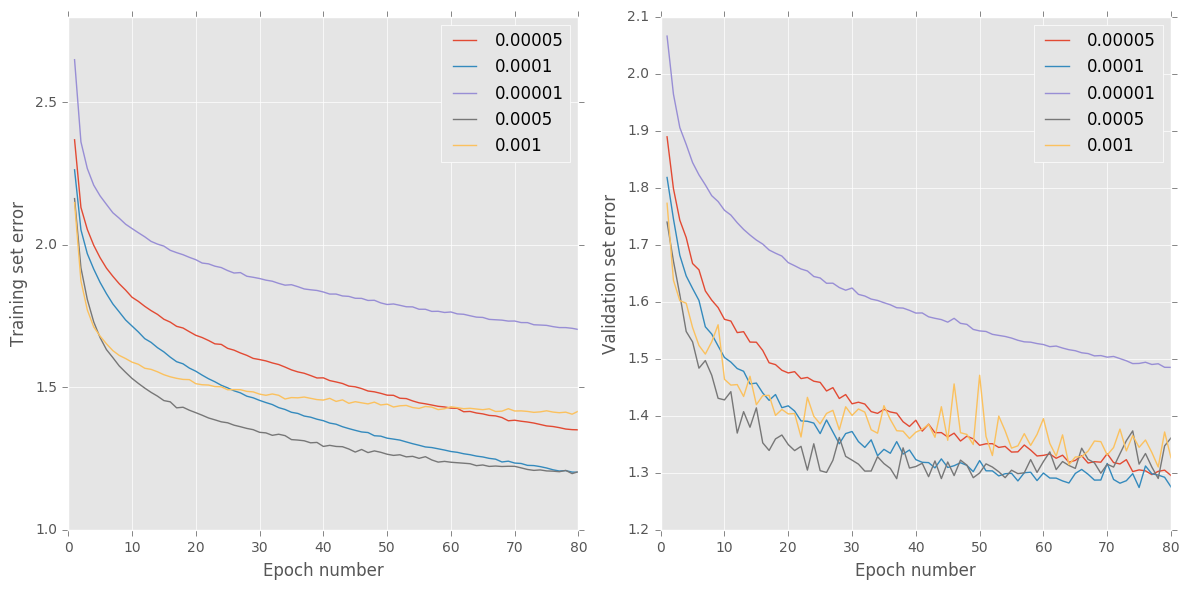

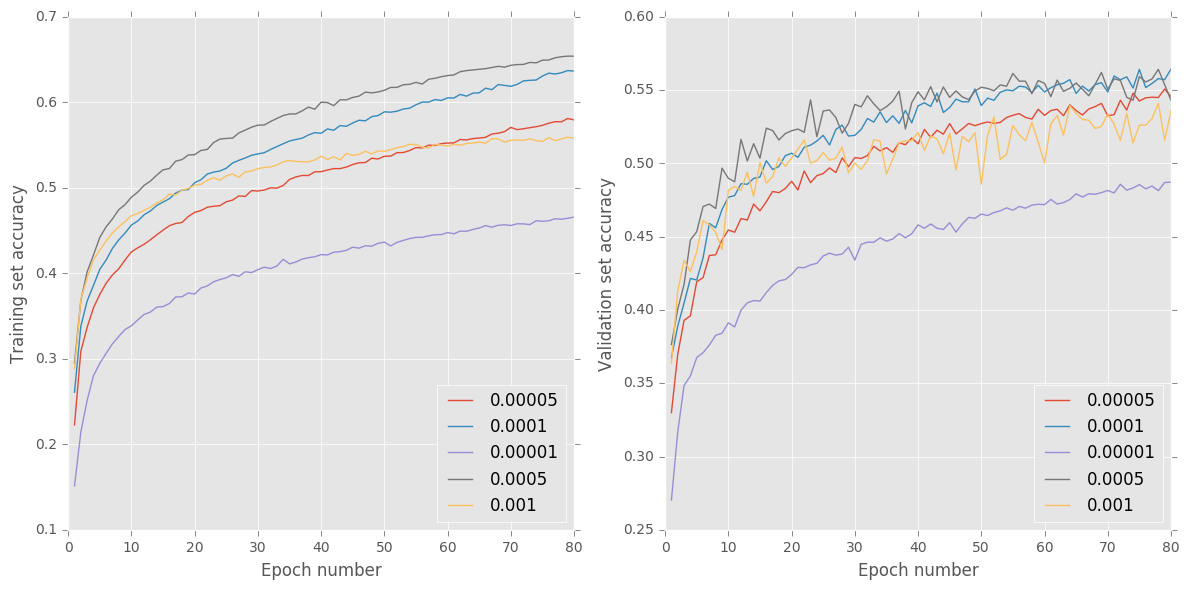

In [8]:
plot_error_and_accuracy(run_info, '3_layers_wL2_wDropout_over_Learning_rates')

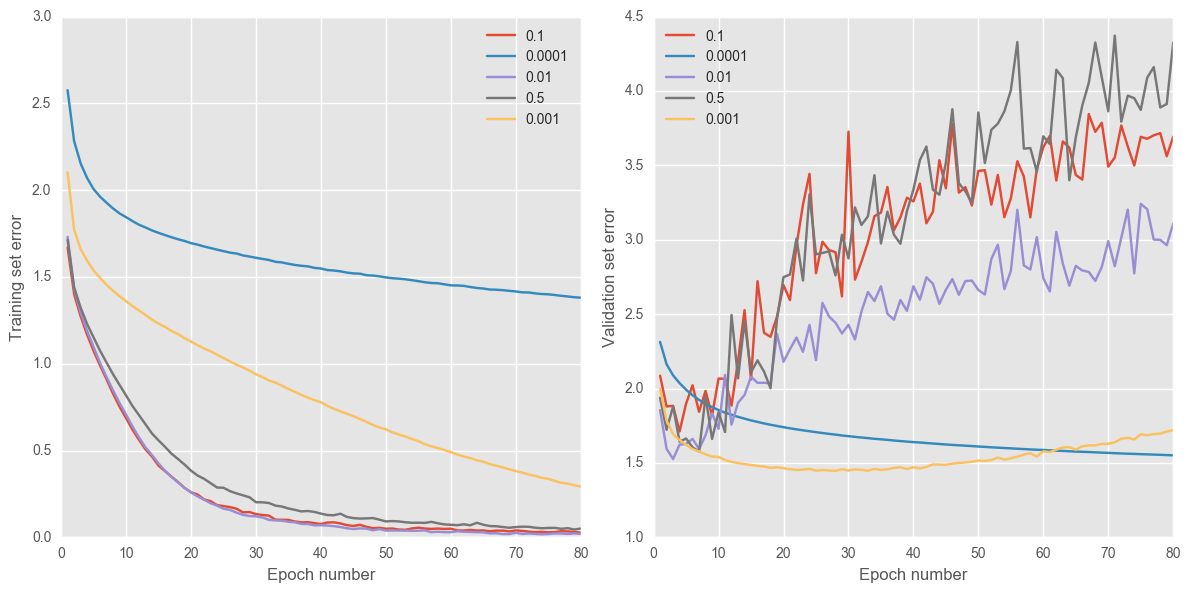

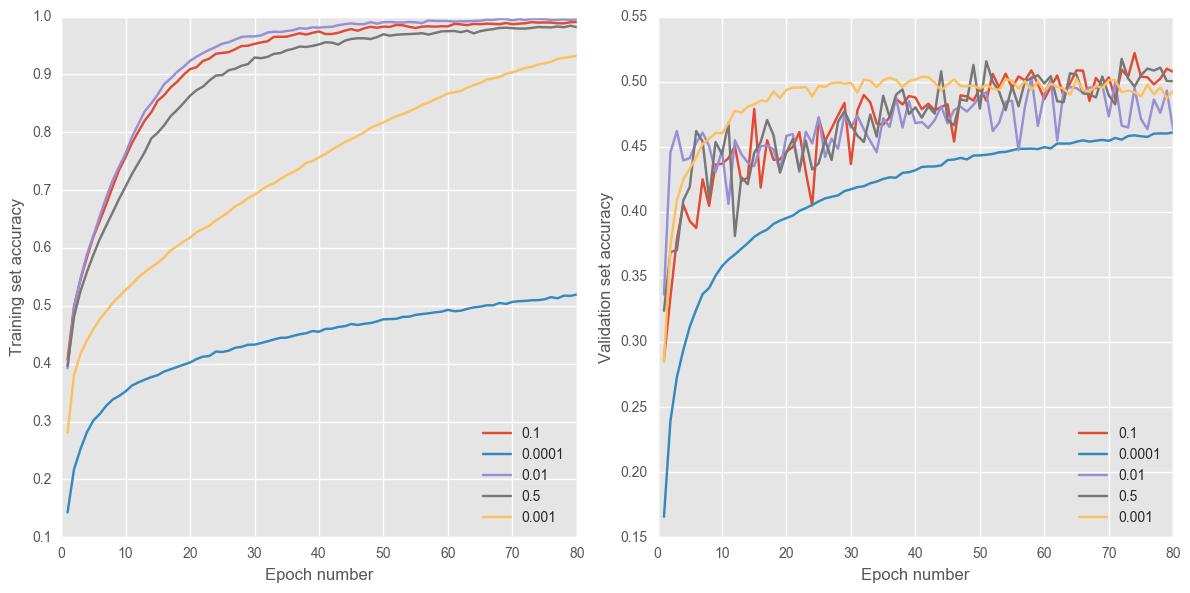

In [7]:
import pickle as pcl
def write_to_file(newfile, run_info):
    with open(newfile,'w') as outfile:
        pcl.dump(run_info,outfile)

def read_from_file(newfile):
    run_info = pcl.load(open(newfile,'r'))
    return run_info
run = read_from_file('CIFAR100_BatchNorm.txt')
plot_error_and_accuracy(run, 'CIFAR100_Batch_learning')

### Confusion Matrix

In [7]:
#source: IAML lab
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix', filename='confusion_matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.tight_layout() # This minimises whitespace around the axes.
    fig.savefig(filename+'_cm.pdf') # Save figure to current directory in PDF format

Model: Final_Model
End of epoch 05: err(train)=1.8631 acc(train)=0.4054
                 err(valid)=1.6340 acc(va00lid)=0.4265
End of epoch 10: err(train)=1.7174 acc(train)=0.4542
                 err(valid)=1.5168 acc(va00lid)=0.4677
End of epoch 15: err(train)=1.6301 acc(train)=0.4795
                 err(valid)=1.4479 acc(va00lid)=0.4904
End of epoch 20: err(train)=1.5616 acc(train)=0.5018
                 err(valid)=1.4008 acc(va00lid)=0.5102
End of epoch 25: err(train)=1.5022 acc(train)=0.5252
                 err(valid)=1.3666 acc(va00lid)=0.5246
End of epoch 30: err(train)=1.4536 acc(train)=0.5381
                 err(valid)=1.3526 acc(va00lid)=0.5261
End of epoch 35: err(train)=1.4151 acc(train)=0.5545
                 err(valid)=1.3328 acc(va00lid)=0.5342
End of epoch 40: err(train)=1.3836 acc(train)=0.5657
                 err(valid)=1.3112 acc(va00lid)=0.5402
End of epoch 45: err(train)=1.3510 acc(train)=0.5791
                 err(valid)=1.3082 acc(va00lid)=0.5469
End of ep

/afs/inf.ed.ac.uk/user/s16/s1687053/miniconda2/envs/mlp/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/afs/inf.ed.ac.uk/user/s16/s1687053/miniconda2/envs/mlp/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


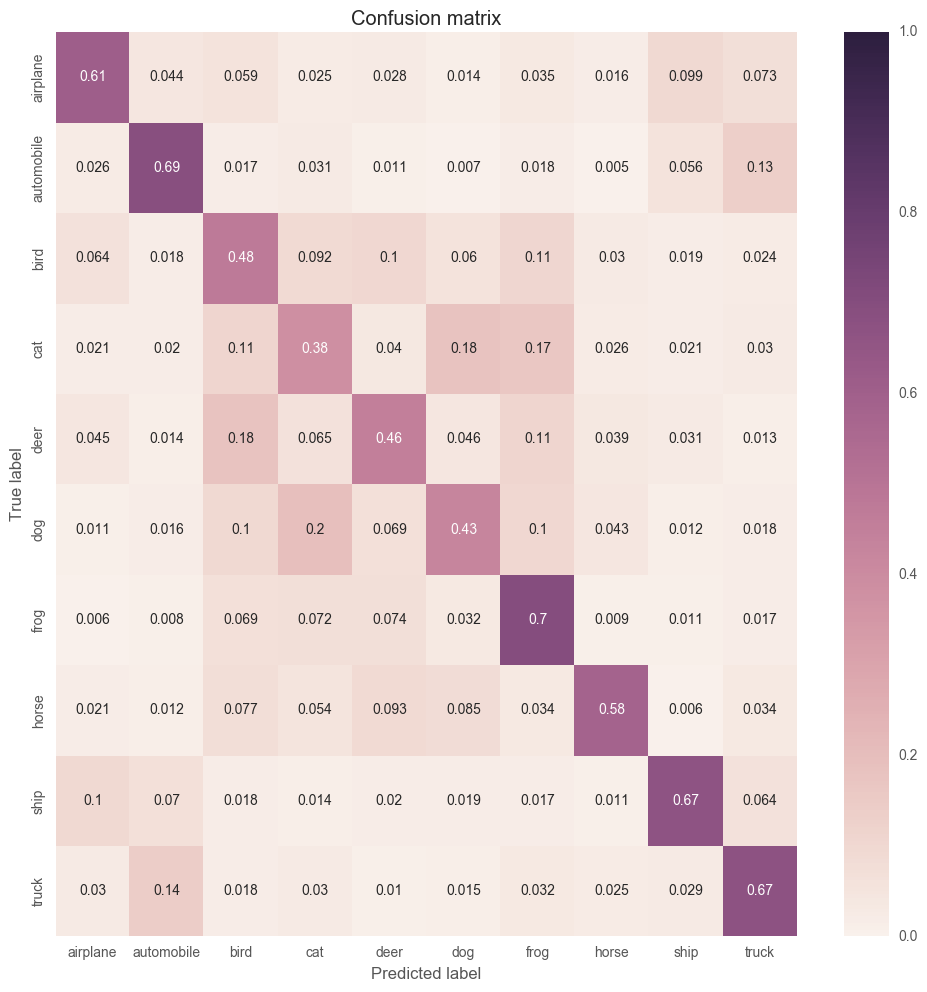

In [8]:
    run_info = {}
    num_hidden = 512
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)


    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.softplus(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.softplus(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    regularizers = tf.reduce_sum(tf.square(weights_1)) + tf.reduce_sum(tf.square(weights_2)) + tf.reduce_sum(tf.square(weights_3)) + tf.reduce_sum(tf.square(weights_4))
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets) + 0.0001 * regularizers)
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.softplus(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.softplus(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.softplus(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format('Final_Model'))
        for e in range(100):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(va00lid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
                
                            
            for input_batch2, target_batch2 in valid_data2:
                y_pred = sess.run(tf.nn.softmax(v_outputs), feed_dict={inputs: input_batch2}) 
                y_true = target_batch2
                y_true_t = tf.argmax(y_true, 1).eval()
                y_pred_t = tf.argmax(y_pred, 1).eval()

            cm = confusion_matrix(y_true_t, y_pred_t)
            cm_norm = cm/cm.sum(axis=1)[:, np.newaxis].astype(float)
            run_info['Final_Model'] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Max_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        plot_confusion_matrix(cm_norm, classes=valid_data2.label_map, filename='Final_Model_CM')

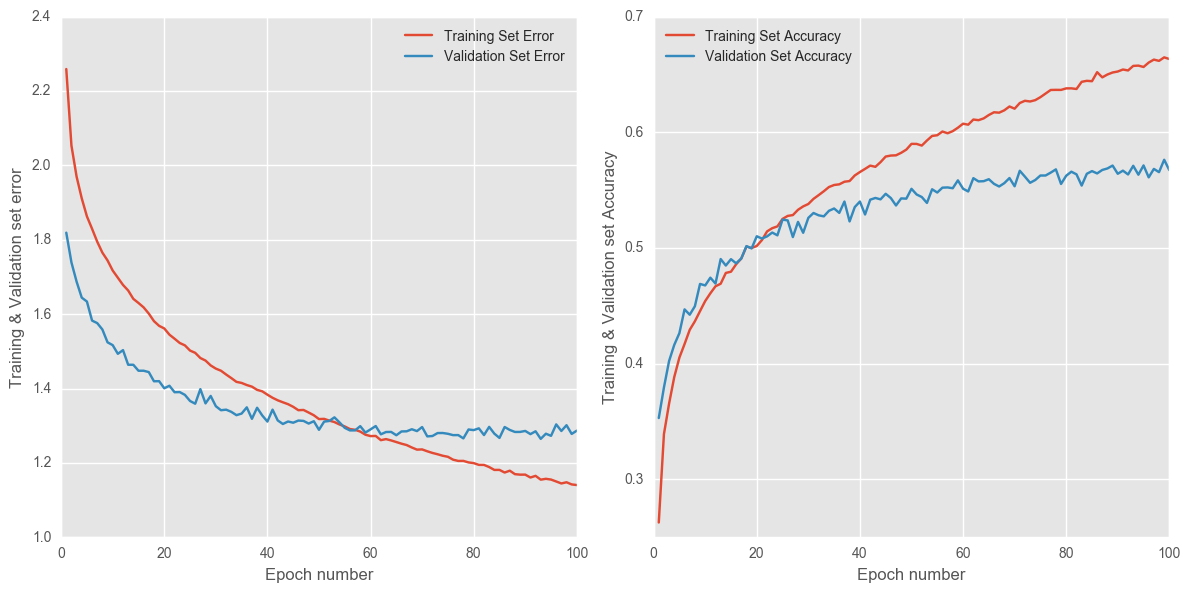

In [9]:
plot_error_and_accuracy_single(run_info, 'Final_model')